In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_ZN
working_dir = fs.WORKING_DIR_ZN
fs.setup_pest_zn()

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_zn
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_zones/freyberg_zn/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGIC

/Users/jwhite/Dev/python/pyemu/pyemu/pst/pst_utils.py:419: UserWarning: pst_from_io_files has moved to pyemu.helpers and is also now avaiable as a Pst class method (Pst.from_io_files())
  "now avaiable as a Pst class method (Pst.from_io_files())")


run():./inschek freyberg.travel.ins freyberg.travel
run():./inschek vol.dat.ins vol.dat
run():./pestchek freyberg_zn.pst
run():./pestpp freyberg_zn.init.pst


calculate an initial Jacobian (``noptmax`` = -1)

In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = -1
pst.write(os.path.join(working_dir,pst_name))
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():pestpp freyberg_zn.pst


In [6]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace(".pst",".jcb")),verbose=True)

2017-08-31 16:06:48.992149 starting: pre-loading base components
2017-08-31 16:06:48.992474 starting: loading jco: freyberg_zn/freyberg_zn.jcb
2017-08-31 16:06:48.997455 finished: loading jco: freyberg_zn/freyberg_zn.jcb took: 0:00:00.004981
2017-08-31 16:06:48.997626 starting: loading pst: freyberg_zn/freyberg_zn.pst
2017-08-31 16:06:49.041782 finished: loading pst: freyberg_zn/freyberg_zn.pst took: 0:00:00.044156
2017-08-31 16:06:49.041879 starting: loading parcov
2017-08-31 16:06:49.084632 finished: loading parcov took: 0:00:00.042753
2017-08-31 16:06:49.084728 starting: loading obscov
2017-08-31 16:06:49.299647 finished: loading obscov took: 0:00:00.214919
2017-08-31 16:06:49.299772 starting: loading forecasts
2017-08-31 16:06:49.313405 finished: loading forecasts took: 0:00:00.013633
2017-08-31 16:06:49.313499 forecast names: fr03c16_19750102,fr03c10_19750102,fr04c9_19750102,fr10c2_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c5_19750102,fr27c7_

In [7]:
sc.get_parameter_summary()

2017-08-31 16:06:52.814725 starting: Schur's complement
2017-08-31 16:06:52.815231 starting: xtqx
2017-08-31 16:06:52.854657 finished: xtqx took: 0:00:00.039426
2017-08-31 16:06:52.855232 finished: Schur's complement took: 0:00:00.040507


,percent_reduction,post_var,prior_var
rch_0,99.955216,0.000001,0.003076
rch_1,0.000000,0.003076,0.003076
hk_z01,0.256132,0.249360,0.250000
hk_z02,98.097223,0.004757,0.250000
hk_z03,99.297684,0.001756,0.250000
hk_z04,98.033192,0.004917,0.250000
hk_z05,96.670536,0.008324,0.250000
hk_z06,96.901966,0.007745,0.250000


In [8]:
sc.get_forecast_summary()

2017-08-31 16:06:53.262530 starting: propagating prior to predictions
2017-08-31 16:06:53.263166 finished: propagating prior to predictions took: 0:00:00.000636
2017-08-31 16:06:53.263263 starting: propagating posterior to predictions
2017-08-31 16:06:53.263639 finished: propagating posterior to predictions took: 0:00:00.000376


,percent_reduction,post_var,prior_var
fr09c15_19750102,99.369085,1.206544e-02,1.912373e+00
fr01c13_19750102,98.871221,5.817078e-03,5.153424e-01
fr14c11_19750102,99.087282,4.375134e-03,4.793521e-01
travel_time,98.653699,5.344750e+06,3.969951e+08
fr27c7_19750102,99.818500,8.315040e-03,4.581293e+00
fr23c16_19750102,99.439189,1.886773e-03,3.364362e-01
fr22c11_19750102,99.243124,8.652017e-03,1.143122e+00
fr30c16_19750102,99.668178,1.033549e-03,3.114767e-01
flx_river_l_19750102,99.299080,1.011038e+02,1.442445e+04
fr03c16_19750102,99.935180,5.932247e-05,9.151856e-02


# Parameter by parameter, fix the parameter and see the impact on forecast uncertainty (simulating perfect knowledge of the parameter)

In [9]:
sc_par_contribution = sc.get_par_contribution()
sc_par_contribution

2017-08-31 16:07:13.615975 starting: calculating contribution from parameters
2017-08-31 16:07:13.616440 starting: calculating contribution from: hk_z06

2017-08-31 16:07:13.793864 finished: calculating contribution from: hk_z06
 took: 0:00:00.177424
2017-08-31 16:07:13.793983 starting: calculating contribution from: hk_z02

2017-08-31 16:07:13.968368 finished: calculating contribution from: hk_z02
 took: 0:00:00.174385
2017-08-31 16:07:13.968521 starting: calculating contribution from: rch_0

2017-08-31 16:07:14.137680 finished: calculating contribution from: rch_0
 took: 0:00:00.169159
2017-08-31 16:07:14.137806 starting: calculating contribution from: rch_1

2017-08-31 16:07:14.308289 finished: calculating contribution from: rch_1
 took: 0:00:00.170483
2017-08-31 16:07:14.308401 starting: calculating contribution from: hk_z05

2017-08-31 16:07:14.476283 finished: calculating contribution from: hk_z05
 took: 0:00:00.167882
2017-08-31 16:07:14.476405 starting: calculating contribution

,flx_river_l_19750102,fr01c13_19750102,fr02c02_19750102,fr03c10_19750102,fr03c16_19750102,fr04c9_19750102,fr09c15_19750102,fr10c2_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c10_19750102,fr25c5_19750102,fr27c7_19750102,fr30c16_19750102,fr34c8_19750102,fr35c11_19750102,travel_time
base,101.103808,0.005817,0.039963,0.006623,0.000059,0.010125,0.012065,0.023913,0.004375,0.006880,0.008652,0.001887,0.026497,0.009281,0.008315,0.001034,0.019752,0.006640,5.344750e+06
hk_z06,39.412836,0.005746,0.039828,0.006616,0.000059,0.010123,0.011851,0.023866,0.004373,0.005858,0.002799,0.001510,0.012121,0.008611,0.006572,0.000706,0.003354,0.000904,2.931063e+06
hk_z02,101.093213,0.000082,0.009527,0.003482,0.000059,0.004948,0.001687,0.014204,0.003680,0.006449,0.008651,0.001765,0.026171,0.006910,0.007860,0.001034,0.019739,0.006549,4.730754e+06
rch_0,89.972292,0.005596,0.038944,0.006569,0.000059,0.009974,0.011781,0.023514,0.002860,0.003636,0.007694,0.001684,0.018412,0.009164,0.008157,0.000827,0.019261,0.005635,3.399541e+06
rch_1,101.091083,0.005817,0.039963,0.006623,0.000059,0.010125,0.012065,0.023913,0.004375,0.006880,0.008652,0.001887,0.026497,0.009281,0.008315,0.001034,0.019752,0.006640,5.344750e+06
hk_z05,85.744579,0.005589,0.039262,0.006622,0.000059,0.010102,0.011611,0.023696,0.003967,0.003710,0.001263,0.001771,0.001747,0.009042,0.008123,0.001022,0.012551,0.000101,6.840298e+05
hk_z04,98.897674,0.004946,0.037617,0.006536,0.000056,0.010081,0.009958,0.023506,0.000926,0.000059,0.007099,0.001399,0.012692,0.008528,0.007867,0.000972,0.019639,0.003947,1.658019e+06
hk_z03,101.102401,0.001064,0.023331,0.001729,0.000047,0.002606,0.000017,0.021268,0.003155,0.005909,0.008649,0.001637,0.025741,0.007317,0.007455,0.001033,0.019679,0.006406,4.467331e+06
hk_z01,101.103319,0.005686,0.037758,0.006616,0.000059,0.010124,0.011995,0.023912,0.004372,0.006879,0.008651,0.001886,0.026497,0.009247,0.008312,0.001033,0.019751,0.006640,5.344694e+06


# We can see how much worse forecasts get without an observation (flipping that around, how valuable is each observation to the forecasts)

In [18]:
sc_removed_import = sc.get_removed_obs_importance()
sc_removed_import_scaled = sc_removed_import.copy()
sc_removed_import

2017-08-31 16:11:11.715272 finished: calculating importance of observations took: 0:02:13.043354
2017-08-31 16:11:11.716474 finished: calculating importance of observations by removing: ['cr16c17_19700102']
 took: 0:02:13.043200
2017-08-31 16:11:11.727919 finished: calculating importance of observations by removing: ['cr04c9_19700102']
 took: 0:02:13.043361
2017-08-31 16:11:11.737134 finished: calculating importance of observations by removing: ['cr22c11_19700102']
 took: 0:02:13.042359
2017-08-31 16:11:11.747024 finished: calculating importance of observations by removing: ['cr30c16_19700102']
 took: 0:02:13.042715
2017-08-31 16:11:11.757441 finished: calculating importance of observations by removing: ['cr03c16_19700102']
 took: 0:02:13.042887
2017-08-31 16:11:11.767168 finished: calculating importance of observations by removing: ['cr25c5_19700102']
 took: 0:02:13.043191
2017-08-31 16:11:11.778947 finished: calculating importance of observations by removing: ['cr35c11_19700102']
 to

,flx_river_l_19750102,fr01c13_19750102,fr02c02_19750102,fr03c10_19750102,fr03c16_19750102,fr04c9_19750102,fr09c15_19750102,fr10c2_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c10_19750102,fr25c5_19750102,fr27c7_19750102,fr30c16_19750102,fr34c8_19750102,fr35c11_19750102,travel_time
base,101.103808,0.005817,0.039963,0.006623,0.000059,0.010125,0.012065,0.023913,0.004375,0.006880,0.008652,0.001887,0.026497,0.009281,0.008315,0.001034,0.019752,0.006640,5.344750e+06
cr16c17_19700102,103.137785,0.006122,0.040691,0.006623,0.000061,0.010144,0.012785,0.024050,0.006609,0.011412,0.009603,0.002222,0.035310,0.010170,0.008562,0.001082,0.019783,0.008309,7.582070e+06
cr04c9_19700102,101.574101,0.008328,0.043808,0.013274,0.000091,0.020239,0.022002,0.023941,0.004700,0.006928,0.008757,0.001987,0.026543,0.012440,0.008900,0.001050,0.019820,0.006641,5.473427e+06
cr22c11_19700102,119.632762,0.005835,0.039965,0.006772,0.000060,0.010365,0.012204,0.023944,0.004723,0.006937,0.014457,0.002732,0.038235,0.009387,0.008549,0.001051,0.025393,0.009829,6.917262e+06
cr30c16_19700102,106.140664,0.005818,0.039974,0.006632,0.000059,0.010139,0.012067,0.023919,0.004398,0.006899,0.008656,0.001900,0.026514,0.009353,0.008628,0.001092,0.020576,0.006666,5.351456e+06
cr03c16_19700102,101.104095,0.005817,0.040001,0.006644,0.000060,0.010151,0.012081,0.023981,0.004379,0.006884,0.008652,0.001888,0.026500,0.009281,0.008318,0.001034,0.019752,0.006641,5.346073e+06
cr25c5_19700102,102.260090,0.006543,0.042886,0.007819,0.000060,0.012155,0.013783,0.024204,0.004575,0.007136,0.009128,0.002078,0.027112,0.015229,0.010027,0.001101,0.019940,0.006657,5.544792e+06
cr35c11_19700102,103.239381,0.005906,0.040269,0.006632,0.000059,0.010159,0.012215,0.024010,0.004591,0.008372,0.011897,0.001924,0.037969,0.009306,0.008317,0.001037,0.021490,0.009263,7.512533e+06
cr10c2_19700102,101.112367,0.116700,1.359173,0.007460,0.001127,0.010134,0.061006,0.991974,0.005538,0.007080,0.008653,0.001898,0.026500,0.017827,0.010727,0.001046,0.019752,0.006640,7.976053e+06
flx_river_l_19700102,443.201039,0.013951,0.485376,0.103932,0.001688,0.145262,0.033664,0.687214,0.013483,0.012906,0.047615,0.010018,0.113031,0.323001,0.206832,0.010822,0.066881,0.008915,1.852502e+07


In [19]:
# let's scale this
for cc in sc_removed_import.columns:
    sc_removed_import_scaled[cc]  =  100*(sc_removed_import_scaled[cc]-sc_removed_import_scaled[cc].loc['base'])/ \
        sc_removed_import_scaled[cc].loc['base']
sc_removed_import_scaled

,flx_river_l_19750102,fr01c13_19750102,fr02c02_19750102,fr03c10_19750102,fr03c16_19750102,fr04c9_19750102,fr09c15_19750102,fr10c2_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c10_19750102,fr25c5_19750102,fr27c7_19750102,fr30c16_19750102,fr34c8_19750102,fr35c11_19750102,travel_time
base,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cr16c17_19700102,2.011771,5.237478,1.822755,0.000193,2.544845,0.190261,5.960937,0.571049,51.068158,65.887050,10.988031,17.749494,33.259125,9.584628,2.971635,4.656095,0.159300,25.129008,41.860149
cr04c9_19700102,0.465158,43.159408,9.622459,100.404053,52.585938,99.897048,82.353950,0.116254,7.433686,0.701148,1.208646,5.336832,0.173831,34.037670,7.034989,1.579425,0.348908,0.016740,2.407538
cr22c11_19700102,18.326664,0.304842,0.006079,2.249955,1.539845,2.373219,1.148631,0.128771,7.959514,0.840990,67.091619,44.790391,44.296418,1.141253,2.819280,1.714581,28.563491,48.022100,29.421632
cr30c16_19700102,4.981866,0.007627,0.029389,0.135380,0.135801,0.144425,0.008885,0.024111,0.526433,0.275912,0.043279,0.680558,0.061717,0.775911,3.759185,5.660051,4.174510,0.384263,0.125470
cr03c16_19700102,0.000284,0.000389,0.094673,0.304351,0.619575,0.259573,0.129230,0.283158,0.090305,0.058575,0.000198,0.066384,0.008230,0.007410,0.038894,0.003378,0.002790,0.013602,0.024755
cr25c5_19700102,1.143659,12.480384,7.315708,18.050253,1.337957,20.054010,14.236459,1.217345,4.561277,3.730568,5.502054,10.129942,2.318558,64.097005,20.593068,6.539642,0.956029,0.249102,3.742786
cr35c11_19700102,2.112258,1.534461,0.766709,0.124889,0.163576,0.342247,1.240454,0.406064,4.936959,21.689637,37.504839,1.979058,43.292219,0.271887,0.023838,0.308143,8.800519,39.504358,40.559115
cr10c2_19700102,0.008466,1906.160548,3301.102633,12.624206,1799.563493,0.094139,405.624427,4048.237866,26.567869,2.917039,0.013592,0.573830,0.008377,92.089791,29.002144,1.196514,0.001812,0.000740,49.231563
flx_river_l_19700102,338.362361,139.833991,1114.570869,1469.172197,2744.869380,1334.730738,179.014285,2773.791088,208.167677,87.602882,450.337613,430.970939,326.576445,3380.355886,2387.448555,947.103306,238.613023,34.251817,246.602277


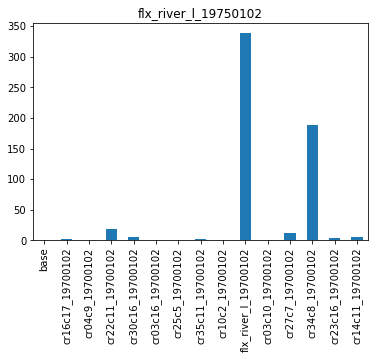

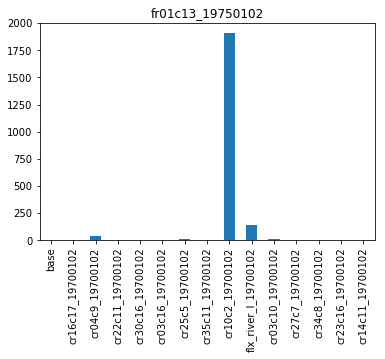

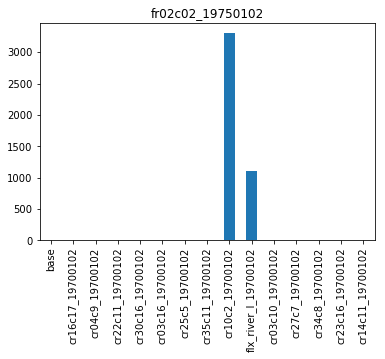

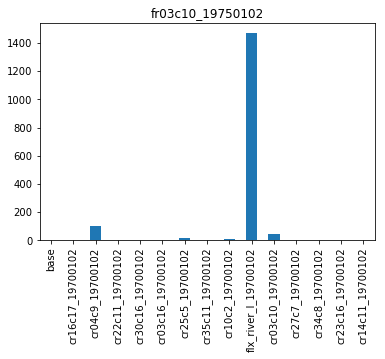

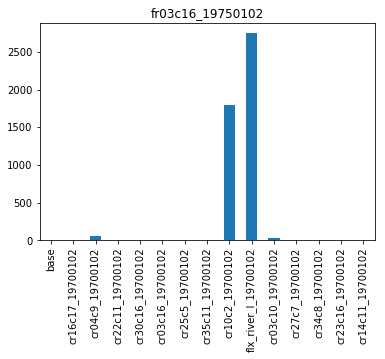

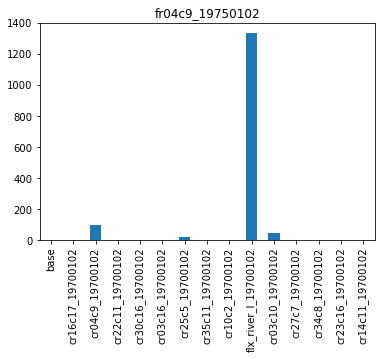

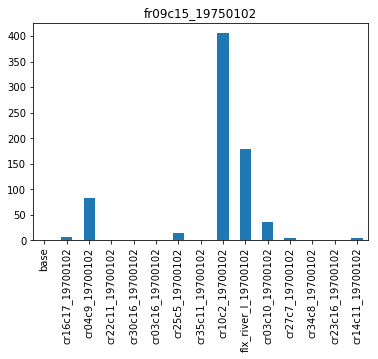

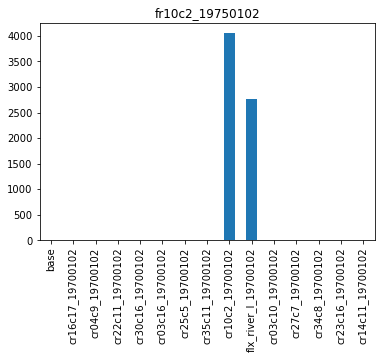

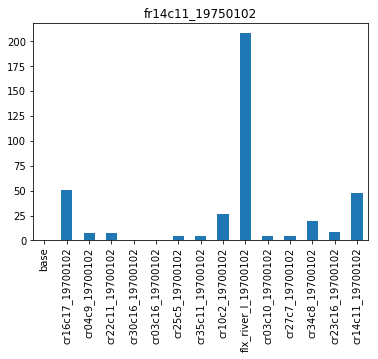

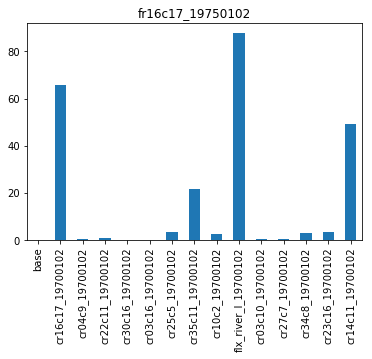

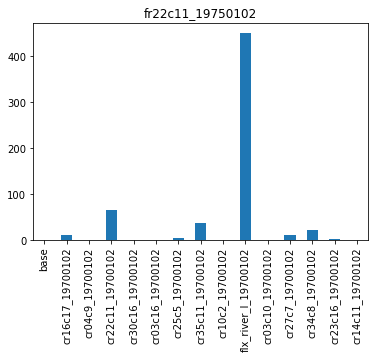

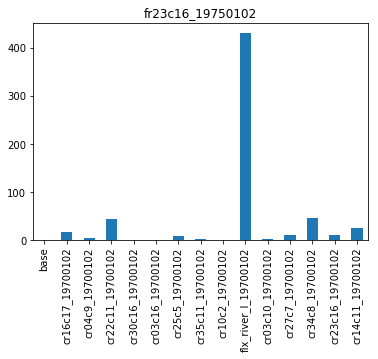

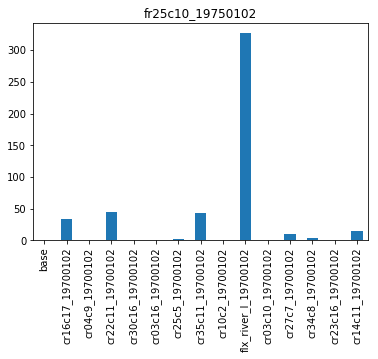

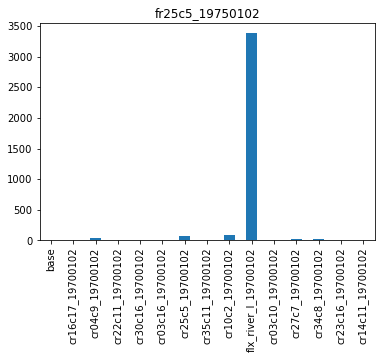

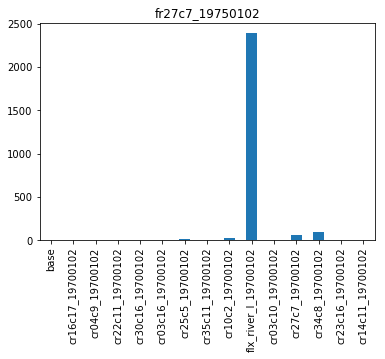

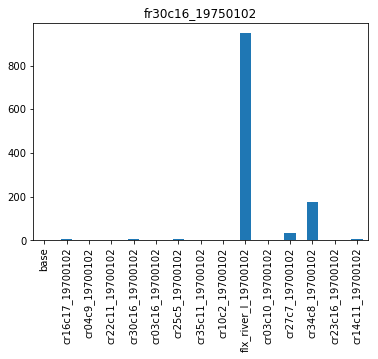

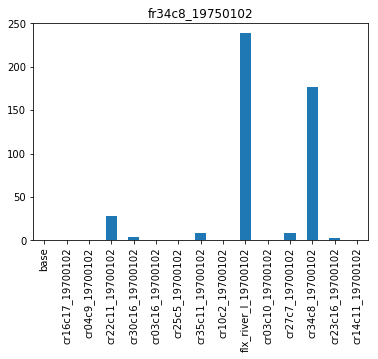

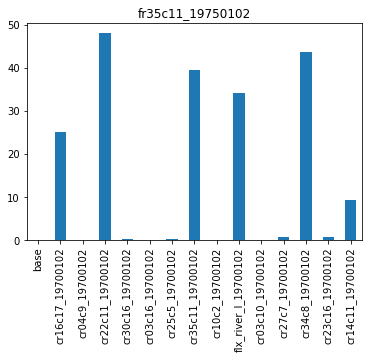

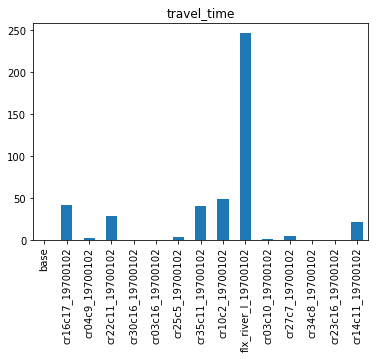

In [20]:
for cc in sc_removed_import_scaled.columns:
    plt.figure()
    sc_removed_import_scaled[cc].plot(kind='bar')
    plt.title(cc)

In [23]:
obs = sc.pst.observation_data
obs
pobs_names = list(obs.loc[obs.obgnme=="pothead","obsnme"])
len(pobs_names)

610

In [24]:
df = sc.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)

2017-08-31 16:16:40.200110 resetting zero weights to 1.0
2017-08-31 16:16:40.484817 starting: resetting zero weight obs in base_obslist
2017-08-31 16:16:40.639572 finished: resetting zero weight obs in base_obslist took: 0:00:00.154755
2017-08-31 16:16:40.639670 starting: resetting zero weight obs in pr21c13_19700102
2017-08-31 16:16:40.650145 finished: resetting zero weight obs in pr21c13_19700102 took: 0:00:00.010475
2017-08-31 16:16:40.650214 starting: resetting zero weight obs in pr26c13_19700102
2017-08-31 16:16:40.659896 finished: resetting zero weight obs in pr26c13_19700102 took: 0:00:00.009682
2017-08-31 16:16:40.660008 starting: resetting zero weight obs in pr35c18_19700102
2017-08-31 16:16:40.670551 finished: resetting zero weight obs in pr35c18_19700102 took: 0:00:00.010543
2017-08-31 16:16:40.670622 starting: resetting zero weight obs in pr13c14_19700102
2017-08-31 16:16:40.680634 finished: resetting zero weight obs in pr13c14_19700102 took: 0:00:00.010012
2017-08-31 16:16

2017-08-31 16:16:41.255731 starting: resetting zero weight obs in pr36c09_19700102
2017-08-31 16:16:41.268162 finished: resetting zero weight obs in pr36c09_19700102 took: 0:00:00.012431
2017-08-31 16:16:41.268513 starting: resetting zero weight obs in pr01c05_19700102
2017-08-31 16:16:41.281507 finished: resetting zero weight obs in pr01c05_19700102 took: 0:00:00.012994
2017-08-31 16:16:41.281610 starting: resetting zero weight obs in pr35c12_19700102
2017-08-31 16:16:41.295285 finished: resetting zero weight obs in pr35c12_19700102 took: 0:00:00.013675
2017-08-31 16:16:41.295366 starting: resetting zero weight obs in pr33c03_19700102
2017-08-31 16:16:41.308190 finished: resetting zero weight obs in pr33c03_19700102 took: 0:00:00.012824
2017-08-31 16:16:41.308282 starting: resetting zero weight obs in pr17c16_19700102
2017-08-31 16:16:41.321459 finished: resetting zero weight obs in pr17c16_19700102 took: 0:00:00.013177
2017-08-31 16:16:41.321543 starting: resetting zero weight obs in

2017-08-31 16:16:41.892691 starting: resetting zero weight obs in pr09c03_19700102
2017-08-31 16:16:41.907730 finished: resetting zero weight obs in pr09c03_19700102 took: 0:00:00.015039
2017-08-31 16:16:41.907837 starting: resetting zero weight obs in pr37c05_19700102
2017-08-31 16:16:41.922795 finished: resetting zero weight obs in pr37c05_19700102 took: 0:00:00.014958
2017-08-31 16:16:41.922894 starting: resetting zero weight obs in pr07c07_19700102
2017-08-31 16:16:41.936974 finished: resetting zero weight obs in pr07c07_19700102 took: 0:00:00.014080
2017-08-31 16:16:41.937085 starting: resetting zero weight obs in pr25c06_19700102
2017-08-31 16:16:41.951153 finished: resetting zero weight obs in pr25c06_19700102 took: 0:00:00.014068
2017-08-31 16:16:41.951247 starting: resetting zero weight obs in pr13c11_19700102
2017-08-31 16:16:41.965407 finished: resetting zero weight obs in pr13c11_19700102 took: 0:00:00.014160
2017-08-31 16:16:41.965493 starting: resetting zero weight obs in

2017-08-31 16:16:42.758311 finished: resetting zero weight obs in pr28c08_19700102 took: 0:00:00.016389
2017-08-31 16:16:42.758413 starting: resetting zero weight obs in pr27c08_19700102
2017-08-31 16:16:42.774387 finished: resetting zero weight obs in pr27c08_19700102 took: 0:00:00.015974
2017-08-31 16:16:42.774482 starting: resetting zero weight obs in pr05c15_19700102
2017-08-31 16:16:42.790139 finished: resetting zero weight obs in pr05c15_19700102 took: 0:00:00.015657
2017-08-31 16:16:42.790224 starting: resetting zero weight obs in pr15c12_19700102
2017-08-31 16:16:42.805465 finished: resetting zero weight obs in pr15c12_19700102 took: 0:00:00.015241
2017-08-31 16:16:42.805535 starting: resetting zero weight obs in pr36c16_19700102
2017-08-31 16:16:42.819779 finished: resetting zero weight obs in pr36c16_19700102 took: 0:00:00.014244
2017-08-31 16:16:42.819849 starting: resetting zero weight obs in pr11c11_19700102
2017-08-31 16:16:42.835408 finished: resetting zero weight obs in

2017-08-31 16:16:43.600353 finished: resetting zero weight obs in pr32c13_19700102 took: 0:00:00.017012
2017-08-31 16:16:43.600507 starting: resetting zero weight obs in pr29c09_19700102
2017-08-31 16:16:43.617811 finished: resetting zero weight obs in pr29c09_19700102 took: 0:00:00.017304
2017-08-31 16:16:43.617914 starting: resetting zero weight obs in pr20c11_19700102
2017-08-31 16:16:43.634001 finished: resetting zero weight obs in pr20c11_19700102 took: 0:00:00.016087
2017-08-31 16:16:43.634117 starting: resetting zero weight obs in pr37c06_19700102
2017-08-31 16:16:43.649848 finished: resetting zero weight obs in pr37c06_19700102 took: 0:00:00.015731
2017-08-31 16:16:43.649938 starting: resetting zero weight obs in pr11c18_19700102
2017-08-31 16:16:43.668777 finished: resetting zero weight obs in pr11c18_19700102 took: 0:00:00.018839
2017-08-31 16:16:43.668872 starting: resetting zero weight obs in pr18c15_19700102
2017-08-31 16:16:43.683988 finished: resetting zero weight obs in

2017-08-31 16:16:44.476696 finished: resetting zero weight obs in pr27c12_19700102 took: 0:00:00.018029
2017-08-31 16:16:44.477021 starting: resetting zero weight obs in pr19c10_19700102
2017-08-31 16:16:44.496095 finished: resetting zero weight obs in pr19c10_19700102 took: 0:00:00.019074
2017-08-31 16:16:44.496202 starting: resetting zero weight obs in pr30c09_19700102
2017-08-31 16:16:44.512953 finished: resetting zero weight obs in pr30c09_19700102 took: 0:00:00.016751
2017-08-31 16:16:44.513046 starting: resetting zero weight obs in pr38c06_19700102
2017-08-31 16:16:44.530097 finished: resetting zero weight obs in pr38c06_19700102 took: 0:00:00.017051
2017-08-31 16:16:44.530207 starting: resetting zero weight obs in pr14c08_19700102
2017-08-31 16:16:44.547132 finished: resetting zero weight obs in pr14c08_19700102 took: 0:00:00.016925
2017-08-31 16:16:44.547230 starting: resetting zero weight obs in pr17c11_19700102
2017-08-31 16:16:44.563631 finished: resetting zero weight obs in

2017-08-31 16:16:45.349599 starting: resetting zero weight obs in pr10c10_19700102
2017-08-31 16:16:45.368137 finished: resetting zero weight obs in pr10c10_19700102 took: 0:00:00.018538
2017-08-31 16:16:45.368247 starting: resetting zero weight obs in pr11c02_19700102
2017-08-31 16:16:45.386650 finished: resetting zero weight obs in pr11c02_19700102 took: 0:00:00.018403
2017-08-31 16:16:45.386743 starting: resetting zero weight obs in pr21c15_19700102
2017-08-31 16:16:45.404368 finished: resetting zero weight obs in pr21c15_19700102 took: 0:00:00.017625
2017-08-31 16:16:45.404452 starting: resetting zero weight obs in pr34c03_19700102
2017-08-31 16:16:45.420429 finished: resetting zero weight obs in pr34c03_19700102 took: 0:00:00.015977
2017-08-31 16:16:45.420499 starting: resetting zero weight obs in pr27c07_19700102
2017-08-31 16:16:45.436896 finished: resetting zero weight obs in pr27c07_19700102 took: 0:00:00.016397
2017-08-31 16:16:45.436984 starting: resetting zero weight obs in

2017-08-31 16:16:46.241396 starting: resetting zero weight obs in pr01c01_19700102
2017-08-31 16:16:46.260496 finished: resetting zero weight obs in pr01c01_19700102 took: 0:00:00.019100
2017-08-31 16:16:46.260779 starting: resetting zero weight obs in pr21c02_19700102
2017-08-31 16:16:46.278895 finished: resetting zero weight obs in pr21c02_19700102 took: 0:00:00.018116
2017-08-31 16:16:46.278976 starting: resetting zero weight obs in pr35c13_19700102
2017-08-31 16:16:46.297015 finished: resetting zero weight obs in pr35c13_19700102 took: 0:00:00.018039
2017-08-31 16:16:46.297122 starting: resetting zero weight obs in pr33c04_19700102
2017-08-31 16:16:46.315886 finished: resetting zero weight obs in pr33c04_19700102 took: 0:00:00.018764
2017-08-31 16:16:46.315997 starting: resetting zero weight obs in pr32c11_19700102
2017-08-31 16:16:46.333961 finished: resetting zero weight obs in pr32c11_19700102 took: 0:00:00.017964
2017-08-31 16:16:46.334084 starting: resetting zero weight obs in

2017-08-31 16:16:47.121885 finished: resetting zero weight obs in pr30c08_19700102 took: 0:00:00.018884
2017-08-31 16:16:47.121973 starting: resetting zero weight obs in pr15c14_19700102
2017-08-31 16:16:47.141466 finished: resetting zero weight obs in pr15c14_19700102 took: 0:00:00.019493
2017-08-31 16:16:47.141564 starting: resetting zero weight obs in pr38c10_19700102
2017-08-31 16:16:47.160500 finished: resetting zero weight obs in pr38c10_19700102 took: 0:00:00.018936
2017-08-31 16:16:47.160591 starting: resetting zero weight obs in pr03c02_19700102
2017-08-31 16:16:47.178323 finished: resetting zero weight obs in pr03c02_19700102 took: 0:00:00.017732
2017-08-31 16:16:47.178422 starting: resetting zero weight obs in pr16c12_19700102
2017-08-31 16:16:47.196467 finished: resetting zero weight obs in pr16c12_19700102 took: 0:00:00.018045
2017-08-31 16:16:47.196571 starting: resetting zero weight obs in pr03c08_19700102
2017-08-31 16:16:47.214128 finished: resetting zero weight obs in

2017-08-31 16:16:47.958389 starting: resetting zero weight obs in pr36c06_19700102
2017-08-31 16:16:47.977564 finished: resetting zero weight obs in pr36c06_19700102 took: 0:00:00.019175
2017-08-31 16:16:47.977672 starting: resetting zero weight obs in pr05c06_19700102
2017-08-31 16:16:47.997157 finished: resetting zero weight obs in pr05c06_19700102 took: 0:00:00.019485
2017-08-31 16:16:47.997261 starting: resetting zero weight obs in pr06c14_19700102
2017-08-31 16:16:48.015302 finished: resetting zero weight obs in pr06c14_19700102 took: 0:00:00.018041
2017-08-31 16:16:48.015394 starting: resetting zero weight obs in pr29c10_19700102
2017-08-31 16:16:48.033647 finished: resetting zero weight obs in pr29c10_19700102 took: 0:00:00.018253
2017-08-31 16:16:48.033779 starting: resetting zero weight obs in pr22c10_19700102
2017-08-31 16:16:48.051529 finished: resetting zero weight obs in pr22c10_19700102 took: 0:00:00.017750
2017-08-31 16:16:48.051623 starting: resetting zero weight obs in

2017-08-31 16:16:48.828800 starting: resetting zero weight obs in pr01c09_19700102
2017-08-31 16:16:48.847819 finished: resetting zero weight obs in pr01c09_19700102 took: 0:00:00.019019
2017-08-31 16:16:48.848032 starting: resetting zero weight obs in pr06c01_19700102
2017-08-31 16:16:48.866904 finished: resetting zero weight obs in pr06c01_19700102 took: 0:00:00.018872
2017-08-31 16:16:48.867003 starting: resetting zero weight obs in pr28c11_19700102
2017-08-31 16:16:48.886010 finished: resetting zero weight obs in pr28c11_19700102 took: 0:00:00.019007
2017-08-31 16:16:48.886368 starting: resetting zero weight obs in pr01c17_19700102
2017-08-31 16:16:48.904273 finished: resetting zero weight obs in pr01c17_19700102 took: 0:00:00.017905
2017-08-31 16:16:48.904373 starting: resetting zero weight obs in pr31c08_19700102
2017-08-31 16:16:48.922059 finished: resetting zero weight obs in pr31c08_19700102 took: 0:00:00.017686
2017-08-31 16:16:48.922169 starting: resetting zero weight obs in

2017-08-31 16:16:49.719972 finished: resetting zero weight obs in pr27c04_19700102 took: 0:00:00.018611
2017-08-31 16:16:49.720082 starting: resetting zero weight obs in pr16c15_19700102
2017-08-31 16:16:49.739707 finished: resetting zero weight obs in pr16c15_19700102 took: 0:00:00.019625
2017-08-31 16:16:49.739802 starting: resetting zero weight obs in pr10c14_19700102
2017-08-31 16:16:49.758033 finished: resetting zero weight obs in pr10c14_19700102 took: 0:00:00.018231
2017-08-31 16:16:49.758131 starting: resetting zero weight obs in pr14c01_19700102
2017-08-31 16:16:49.776806 finished: resetting zero weight obs in pr14c01_19700102 took: 0:00:00.018675
2017-08-31 16:16:49.776891 starting: resetting zero weight obs in pr05c02_19700102
2017-08-31 16:16:49.793937 finished: resetting zero weight obs in pr05c02_19700102 took: 0:00:00.017046
2017-08-31 16:16:49.794013 starting: resetting zero weight obs in pr25c01_19700102
2017-08-31 16:16:49.811593 finished: resetting zero weight obs in

2017-08-31 16:16:50.573900 starting: resetting zero weight obs in pr20c03_19700102
2017-08-31 16:16:50.591493 finished: resetting zero weight obs in pr20c03_19700102 took: 0:00:00.017593
2017-08-31 16:16:50.591587 starting: resetting zero weight obs in pr33c12_19700102
2017-08-31 16:16:50.610623 finished: resetting zero weight obs in pr33c12_19700102 took: 0:00:00.019036
2017-08-31 16:16:50.610713 starting: resetting zero weight obs in pr05c09_19700102
2017-08-31 16:16:50.626803 finished: resetting zero weight obs in pr05c09_19700102 took: 0:00:00.016090
2017-08-31 16:16:50.626869 starting: resetting zero weight obs in pr32c16_19700102
2017-08-31 16:16:50.643993 finished: resetting zero weight obs in pr32c16_19700102 took: 0:00:00.017124
2017-08-31 16:16:50.644062 starting: resetting zero weight obs in pr21c07_19700102
2017-08-31 16:16:50.661195 finished: resetting zero weight obs in pr21c07_19700102 took: 0:00:00.017133
2017-08-31 16:16:50.661259 starting: resetting zero weight obs in

2017-08-31 16:16:51.390302 starting: calculating importance of observations by adding: ['pr37c09_19700102']

2017-08-31 16:16:51.400686 finished: calculating importance of observations by adding: ['pr37c09_19700102']
 took: 0:00:00.010384
2017-08-31 16:16:51.400747 starting: calculating importance of observations by adding: ['pr14c12_19700102']

2017-08-31 16:16:51.410695 finished: calculating importance of observations by adding: ['pr14c12_19700102']
 took: 0:00:00.009948
2017-08-31 16:16:51.410777 starting: calculating importance of observations by adding: ['pr31c14_19700102']

2017-08-31 16:16:51.421271 finished: calculating importance of observations by adding: ['pr31c14_19700102']
 took: 0:00:00.010494
2017-08-31 16:16:51.421338 starting: calculating importance of observations by adding: ['pr18c01_19700102']

2017-08-31 16:16:51.431988 finished: calculating importance of observations by adding: ['pr18c01_19700102']
 took: 0:00:00.010650
2017-08-31 16:16:51.432193 starting: calcula

2017-08-31 16:16:51.829272 finished: calculating importance of observations by adding: ['pr26c18_19700102']
 took: 0:00:00.009681
2017-08-31 16:16:51.829569 starting: calculating importance of observations by adding: ['pr28c07_19700102']

2017-08-31 16:16:51.838766 finished: calculating importance of observations by adding: ['pr28c07_19700102']
 took: 0:00:00.009197
2017-08-31 16:16:51.838829 starting: calculating importance of observations by adding: ['pr27c03_19700102']

2017-08-31 16:16:51.849136 finished: calculating importance of observations by adding: ['pr27c03_19700102']
 took: 0:00:00.010307
2017-08-31 16:16:51.849243 starting: calculating importance of observations by adding: ['pr29c04_19700102']

2017-08-31 16:16:51.859798 finished: calculating importance of observations by adding: ['pr29c04_19700102']
 took: 0:00:00.010555
2017-08-31 16:16:51.859867 starting: calculating importance of observations by adding: ['pr19c14_19700102']

2017-08-31 16:16:51.869420 finished: calcula

2017-08-31 16:16:52.260721 finished: calculating importance of observations by adding: ['pr01c04_19700102']
 took: 0:00:00.010498
2017-08-31 16:16:52.260830 starting: calculating importance of observations by adding: ['pr24c13_19700102']

2017-08-31 16:16:52.270255 finished: calculating importance of observations by adding: ['pr24c13_19700102']
 took: 0:00:00.009425
2017-08-31 16:16:52.270332 starting: calculating importance of observations by adding: ['pr20c13_19700102']

2017-08-31 16:16:52.281095 finished: calculating importance of observations by adding: ['pr20c13_19700102']
 took: 0:00:00.010763
2017-08-31 16:16:52.281156 starting: calculating importance of observations by adding: ['pr26c08_19700102']

2017-08-31 16:16:52.290168 finished: calculating importance of observations by adding: ['pr26c08_19700102']
 took: 0:00:00.009012
2017-08-31 16:16:52.290255 starting: calculating importance of observations by adding: ['pr03c01_19700102']

2017-08-31 16:16:52.300292 finished: calcula

2017-08-31 16:16:52.700254 starting: calculating importance of observations by adding: ['pr21c11_19700102']

2017-08-31 16:16:52.709912 finished: calculating importance of observations by adding: ['pr21c11_19700102']
 took: 0:00:00.009658
2017-08-31 16:16:52.709974 starting: calculating importance of observations by adding: ['pr23c13_19700102']

2017-08-31 16:16:52.721328 finished: calculating importance of observations by adding: ['pr23c13_19700102']
 took: 0:00:00.011354
2017-08-31 16:16:52.721517 starting: calculating importance of observations by adding: ['pr27c11_19700102']

2017-08-31 16:16:52.732977 finished: calculating importance of observations by adding: ['pr27c11_19700102']
 took: 0:00:00.011460
2017-08-31 16:16:52.733046 starting: calculating importance of observations by adding: ['pr31c06_19700102']

2017-08-31 16:16:52.742615 finished: calculating importance of observations by adding: ['pr31c06_19700102']
 took: 0:00:00.009569
2017-08-31 16:16:52.742701 starting: calcula

2017-08-31 16:16:53.139969 finished: calculating importance of observations by adding: ['pr13c13_19700102']
 took: 0:00:00.009616
2017-08-31 16:16:53.140043 starting: calculating importance of observations by adding: ['pr26c11_19700102']

2017-08-31 16:16:53.150585 finished: calculating importance of observations by adding: ['pr26c11_19700102']
 took: 0:00:00.010542
2017-08-31 16:16:53.150647 starting: calculating importance of observations by adding: ['pr23c05_19700102']

2017-08-31 16:16:53.162597 finished: calculating importance of observations by adding: ['pr23c05_19700102']
 took: 0:00:00.011950
2017-08-31 16:16:53.162741 starting: calculating importance of observations by adding: ['pr22c06_19700102']

2017-08-31 16:16:53.172802 finished: calculating importance of observations by adding: ['pr22c06_19700102']
 took: 0:00:00.010061
2017-08-31 16:16:53.172860 starting: calculating importance of observations by adding: ['pr04c05_19700102']

2017-08-31 16:16:53.182862 finished: calcula

2017-08-31 16:16:53.564204 starting: calculating importance of observations by adding: ['pr27c12_19700102']

2017-08-31 16:16:53.574840 finished: calculating importance of observations by adding: ['pr27c12_19700102']
 took: 0:00:00.010636
2017-08-31 16:16:53.575006 starting: calculating importance of observations by adding: ['pr19c10_19700102']

2017-08-31 16:16:53.586968 finished: calculating importance of observations by adding: ['pr19c10_19700102']
 took: 0:00:00.011962
2017-08-31 16:16:53.587176 starting: calculating importance of observations by adding: ['pr30c09_19700102']

2017-08-31 16:16:53.597350 finished: calculating importance of observations by adding: ['pr30c09_19700102']
 took: 0:00:00.010174
2017-08-31 16:16:53.597413 starting: calculating importance of observations by adding: ['pr38c06_19700102']

2017-08-31 16:16:53.607175 finished: calculating importance of observations by adding: ['pr38c06_19700102']
 took: 0:00:00.009762
2017-08-31 16:16:53.607257 starting: calcula

2017-08-31 16:16:53.996865 finished: calculating importance of observations by adding: ['pr04c04_19700102']
 took: 0:00:00.016483
2017-08-31 16:16:53.996982 starting: calculating importance of observations by adding: ['pr27c18_19700102']

2017-08-31 16:16:54.009862 finished: calculating importance of observations by adding: ['pr27c18_19700102']
 took: 0:00:00.012880
2017-08-31 16:16:54.009958 starting: calculating importance of observations by adding: ['pr02c18_19700102']

2017-08-31 16:16:54.022448 finished: calculating importance of observations by adding: ['pr02c18_19700102']
 took: 0:00:00.012490
2017-08-31 16:16:54.022506 starting: calculating importance of observations by adding: ['pr11c13_19700102']

2017-08-31 16:16:54.032008 finished: calculating importance of observations by adding: ['pr11c13_19700102']
 took: 0:00:00.009502
2017-08-31 16:16:54.032092 starting: calculating importance of observations by adding: ['pr05c18_19700102']

2017-08-31 16:16:54.042517 finished: calcula

2017-08-31 16:16:54.422173 finished: calculating importance of observations by adding: ['pr01c07_19700102']
 took: 0:00:00.009631
2017-08-31 16:16:54.422710 starting: calculating importance of observations by adding: ['pr10c16_19700102']

2017-08-31 16:16:54.433577 finished: calculating importance of observations by adding: ['pr10c16_19700102']
 took: 0:00:00.010867
2017-08-31 16:16:54.433804 starting: calculating importance of observations by adding: ['pr28c13_19700102']

2017-08-31 16:16:54.444076 finished: calculating importance of observations by adding: ['pr28c13_19700102']
 took: 0:00:00.010272
2017-08-31 16:16:54.444158 starting: calculating importance of observations by adding: ['pr06c17_19700102']

2017-08-31 16:16:54.453169 finished: calculating importance of observations by adding: ['pr06c17_19700102']
 took: 0:00:00.009011
2017-08-31 16:16:54.453232 starting: calculating importance of observations by adding: ['pr07c09_19700102']

2017-08-31 16:16:54.462376 finished: calcula

2017-08-31 16:16:54.852355 finished: calculating importance of observations by adding: ['pr28c09_19700102']
 took: 0:00:00.009746
2017-08-31 16:16:54.852416 starting: calculating importance of observations by adding: ['pr36c11_19700102']

2017-08-31 16:16:54.864050 finished: calculating importance of observations by adding: ['pr36c11_19700102']
 took: 0:00:00.011634
2017-08-31 16:16:54.864278 starting: calculating importance of observations by adding: ['pr22c02_19700102']

2017-08-31 16:16:54.873755 finished: calculating importance of observations by adding: ['pr22c02_19700102']
 took: 0:00:00.009477
2017-08-31 16:16:54.873826 starting: calculating importance of observations by adding: ['pr08c01_19700102']

2017-08-31 16:16:54.883243 finished: calculating importance of observations by adding: ['pr08c01_19700102']
 took: 0:00:00.009417
2017-08-31 16:16:54.883318 starting: calculating importance of observations by adding: ['pr35c04_19700102']

2017-08-31 16:16:54.893166 finished: calcula

2017-08-31 16:16:55.277576 finished: calculating importance of observations by adding: ['pr33c05_19700102']
 took: 0:00:00.010403
2017-08-31 16:16:55.277638 starting: calculating importance of observations by adding: ['pr36c13_19700102']

2017-08-31 16:16:55.288841 finished: calculating importance of observations by adding: ['pr36c13_19700102']
 took: 0:00:00.011203
2017-08-31 16:16:55.288926 starting: calculating importance of observations by adding: ['pr24c16_19700102']

2017-08-31 16:16:55.298741 finished: calculating importance of observations by adding: ['pr24c16_19700102']
 took: 0:00:00.009815
2017-08-31 16:16:55.298820 starting: calculating importance of observations by adding: ['pr15c13_19700102']

2017-08-31 16:16:55.307990 finished: calculating importance of observations by adding: ['pr15c13_19700102']
 took: 0:00:00.009170
2017-08-31 16:16:55.308073 starting: calculating importance of observations by adding: ['pr28c01_19700102']

2017-08-31 16:16:55.317990 finished: calcula

2017-08-31 16:16:55.700287 finished: calculating importance of observations by adding: ['pr04c17_19700102']
 took: 0:00:00.009780
2017-08-31 16:16:55.700567 starting: calculating importance of observations by adding: ['pr26c14_19700102']

2017-08-31 16:16:55.711046 finished: calculating importance of observations by adding: ['pr26c14_19700102']
 took: 0:00:00.010479
2017-08-31 16:16:55.711128 starting: calculating importance of observations by adding: ['pr30c12_19700102']

2017-08-31 16:16:55.721237 finished: calculating importance of observations by adding: ['pr30c12_19700102']
 took: 0:00:00.010109
2017-08-31 16:16:55.721306 starting: calculating importance of observations by adding: ['pr28c15_19700102']

2017-08-31 16:16:55.731372 finished: calculating importance of observations by adding: ['pr28c15_19700102']
 took: 0:00:00.010066
2017-08-31 16:16:55.731454 starting: calculating importance of observations by adding: ['pr24c11_19700102']

2017-08-31 16:16:55.740460 finished: calcula

2017-08-31 16:16:56.126616 finished: calculating importance of observations by adding: ['pr17c12_19700102']
 took: 0:00:00.009939
2017-08-31 16:16:56.126689 starting: calculating importance of observations by adding: ['pr37c12_19700102']

2017-08-31 16:16:56.138688 finished: calculating importance of observations by adding: ['pr37c12_19700102']
 took: 0:00:00.011999
2017-08-31 16:16:56.138960 starting: calculating importance of observations by adding: ['pr33c14_19700102']

2017-08-31 16:16:56.149166 finished: calculating importance of observations by adding: ['pr33c14_19700102']
 took: 0:00:00.010206
2017-08-31 16:16:56.149259 starting: calculating importance of observations by adding: ['pr16c14_19700102']

2017-08-31 16:16:56.158375 finished: calculating importance of observations by adding: ['pr16c14_19700102']
 took: 0:00:00.009116
2017-08-31 16:16:56.158457 starting: calculating importance of observations by adding: ['pr08c12_19700102']

2017-08-31 16:16:56.168240 finished: calcula

2017-08-31 16:16:56.543667 finished: calculating importance of observations by adding: ['pr10c02_19700102']
 took: 0:00:00.010029
2017-08-31 16:16:56.543813 starting: calculating importance of observations by adding: ['pr22c16_19700102']

2017-08-31 16:16:56.554060 finished: calculating importance of observations by adding: ['pr22c16_19700102']
 took: 0:00:00.010247
2017-08-31 16:16:56.554132 starting: calculating importance of observations by adding: ['pr23c11_19700102']

2017-08-31 16:16:56.566107 finished: calculating importance of observations by adding: ['pr23c11_19700102']
 took: 0:00:00.011975
2017-08-31 16:16:56.566173 starting: calculating importance of observations by adding: ['pr22c11_19700102']

2017-08-31 16:16:56.575338 finished: calculating importance of observations by adding: ['pr22c11_19700102']
 took: 0:00:00.009165
2017-08-31 16:16:56.575420 starting: calculating importance of observations by adding: ['pr08c02_19700102']

2017-08-31 16:16:56.585373 finished: calcula

2017-08-31 16:16:56.964798 starting: calculating importance of observations by adding: ['pr06c06_19700102']

2017-08-31 16:16:56.974629 finished: calculating importance of observations by adding: ['pr06c06_19700102']
 took: 0:00:00.009831
2017-08-31 16:16:56.974704 starting: calculating importance of observations by adding: ['pr38c14_19700102']

2017-08-31 16:16:56.986279 finished: calculating importance of observations by adding: ['pr38c14_19700102']
 took: 0:00:00.011575
2017-08-31 16:16:56.986367 starting: calculating importance of observations by adding: ['pr31c12_19700102']

2017-08-31 16:16:56.996042 finished: calculating importance of observations by adding: ['pr31c12_19700102']
 took: 0:00:00.009675
2017-08-31 16:16:56.996111 starting: calculating importance of observations by adding: ['pr11c14_19700102']

2017-08-31 16:16:57.005060 finished: calculating importance of observations by adding: ['pr11c14_19700102']
 took: 0:00:00.008949
2017-08-31 16:16:57.005128 starting: calcula

In [25]:
df.min()

flx_river_l_19750102    9.139970e+01
fr01c13_19750102        5.443951e-03
fr02c02_19750102        3.737503e-02
fr03c10_19750102        6.245030e-03
fr03c16_19750102        5.805170e-05
fr04c9_19750102         9.545403e-03
fr09c15_19750102        1.111931e-02
fr10c2_19750102         2.267466e-02
fr14c11_19750102        4.236857e-03
fr16c17_19750102        6.505709e-03
fr22c11_19750102        7.085596e-03
fr23c16_19750102        1.815823e-03
fr25c10_19750102        2.219407e-02
fr25c5_19750102         8.953915e-03
fr27c7_19750102         8.050599e-03
fr30c16_19750102        9.970361e-04
fr34c8_19750102         1.677655e-02
fr35c11_19750102        5.204039e-03
travel_time             4.594877e+06
dtype: float64

In [26]:
df.max()

flx_river_l_19750102    1.011038e+02
fr01c13_19750102        5.817078e-03
fr02c02_19750102        3.996272e-02
fr03c10_19750102        6.623388e-03
fr03c16_19750102        5.932247e-05
fr04c9_19750102         1.012468e-02
fr09c15_19750102        1.206544e-02
fr10c2_19750102         2.391315e-02
fr14c11_19750102        4.375134e-03
fr16c17_19750102        6.879642e-03
fr22c11_19750102        8.652017e-03
fr23c16_19750102        1.886773e-03
fr25c10_19750102        2.649732e-02
fr25c5_19750102         9.280677e-03
fr27c7_19750102         8.315040e-03
fr30c16_19750102        1.033549e-03
fr34c8_19750102         1.975152e-02
fr35c11_19750102        6.640245e-03
travel_time             5.344750e+06
dtype: float64

In [27]:
df1 = sc.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                  reset_zero_weight=True)

2017-08-31 16:17:38.831110 resetting zero weights to 1.0
2017-08-31 16:17:39.113471 starting: resetting zero weight obs in pr21c13_19700102
2017-08-31 16:17:39.124370 finished: resetting zero weight obs in pr21c13_19700102 took: 0:00:00.010899
2017-08-31 16:17:39.124441 starting: resetting zero weight obs in pr26c13_19700102
2017-08-31 16:17:39.135582 finished: resetting zero weight obs in pr26c13_19700102 took: 0:00:00.011141
2017-08-31 16:17:39.135839 starting: resetting zero weight obs in pr35c18_19700102
2017-08-31 16:17:39.145607 finished: resetting zero weight obs in pr35c18_19700102 took: 0:00:00.009768
2017-08-31 16:17:39.145670 starting: resetting zero weight obs in pr13c14_19700102
2017-08-31 16:17:39.155517 finished: resetting zero weight obs in pr13c14_19700102 took: 0:00:00.009847
2017-08-31 16:17:39.155581 starting: resetting zero weight obs in pr28c18_19700102
2017-08-31 16:17:39.165901 finished: resetting zero weight obs in pr28c18_19700102 took: 0:00:00.010320
2017-08-

2017-08-31 16:17:39.754648 finished: resetting zero weight obs in pr35c12_19700102 took: 0:00:00.013034
2017-08-31 16:17:39.754738 starting: resetting zero weight obs in pr33c03_19700102
2017-08-31 16:17:39.769014 finished: resetting zero weight obs in pr33c03_19700102 took: 0:00:00.014276
2017-08-31 16:17:39.769135 starting: resetting zero weight obs in pr17c16_19700102
2017-08-31 16:17:39.781795 finished: resetting zero weight obs in pr17c16_19700102 took: 0:00:00.012660
2017-08-31 16:17:39.781864 starting: resetting zero weight obs in pr05c07_19700102
2017-08-31 16:17:39.794891 finished: resetting zero weight obs in pr05c07_19700102 took: 0:00:00.013027
2017-08-31 16:17:39.795009 starting: resetting zero weight obs in pr18c17_19700102
2017-08-31 16:17:39.807248 finished: resetting zero weight obs in pr18c17_19700102 took: 0:00:00.012239
2017-08-31 16:17:39.807307 starting: resetting zero weight obs in pr26c05_19700102
2017-08-31 16:17:39.819528 finished: resetting zero weight obs in

2017-08-31 16:17:40.397303 finished: resetting zero weight obs in pr07c07_19700102 took: 0:00:00.014841
2017-08-31 16:17:40.397379 starting: resetting zero weight obs in pr25c06_19700102
2017-08-31 16:17:40.411892 finished: resetting zero weight obs in pr25c06_19700102 took: 0:00:00.014513
2017-08-31 16:17:40.411988 starting: resetting zero weight obs in pr13c11_19700102
2017-08-31 16:17:40.427354 finished: resetting zero weight obs in pr13c11_19700102 took: 0:00:00.015366
2017-08-31 16:17:40.427438 starting: resetting zero weight obs in pr11c10_19700102
2017-08-31 16:17:40.440724 finished: resetting zero weight obs in pr11c10_19700102 took: 0:00:00.013286
2017-08-31 16:17:40.440789 starting: resetting zero weight obs in pr29c16_19700102
2017-08-31 16:17:40.454746 finished: resetting zero weight obs in pr29c16_19700102 took: 0:00:00.013957
2017-08-31 16:17:40.454817 starting: resetting zero weight obs in pr06c02_19700102
2017-08-31 16:17:40.468557 finished: resetting zero weight obs in

2017-08-31 16:17:41.260552 finished: resetting zero weight obs in pr15c12_19700102 took: 0:00:00.016060
2017-08-31 16:17:41.260628 starting: resetting zero weight obs in pr36c16_19700102
2017-08-31 16:17:41.276429 finished: resetting zero weight obs in pr36c16_19700102 took: 0:00:00.015801
2017-08-31 16:17:41.276522 starting: resetting zero weight obs in pr11c11_19700102
2017-08-31 16:17:41.291966 finished: resetting zero weight obs in pr11c11_19700102 took: 0:00:00.015444
2017-08-31 16:17:41.292054 starting: resetting zero weight obs in pr36c10_19700102
2017-08-31 16:17:41.307729 finished: resetting zero weight obs in pr36c10_19700102 took: 0:00:00.015675
2017-08-31 16:17:41.307817 starting: resetting zero weight obs in pr26c16_19700102
2017-08-31 16:17:41.323060 finished: resetting zero weight obs in pr26c16_19700102 took: 0:00:00.015243
2017-08-31 16:17:41.323148 starting: resetting zero weight obs in pr18c10_19700102
2017-08-31 16:17:41.338821 finished: resetting zero weight obs in

2017-08-31 16:17:42.122789 finished: resetting zero weight obs in pr18c15_19700102 took: 0:00:00.017718
2017-08-31 16:17:42.122892 starting: resetting zero weight obs in pr17c13_19700102
2017-08-31 16:17:42.140320 finished: resetting zero weight obs in pr17c13_19700102 took: 0:00:00.017428
2017-08-31 16:17:42.140419 starting: resetting zero weight obs in pr07c11_19700102
2017-08-31 16:17:42.156645 finished: resetting zero weight obs in pr07c11_19700102 took: 0:00:00.016226
2017-08-31 16:17:42.156744 starting: resetting zero weight obs in pr25c02_19700102
2017-08-31 16:17:42.174590 finished: resetting zero weight obs in pr25c02_19700102 took: 0:00:00.017846
2017-08-31 16:17:42.174696 starting: resetting zero weight obs in pr13c13_19700102
2017-08-31 16:17:42.192082 finished: resetting zero weight obs in pr13c13_19700102 took: 0:00:00.017386
2017-08-31 16:17:42.192170 starting: resetting zero weight obs in pr26c11_19700102
2017-08-31 16:17:42.208752 finished: resetting zero weight obs in

2017-08-31 16:17:42.976356 finished: resetting zero weight obs in pr30c09_19700102 took: 0:00:00.018338
2017-08-31 16:17:42.976950 starting: resetting zero weight obs in pr38c06_19700102
2017-08-31 16:17:42.994827 finished: resetting zero weight obs in pr38c06_19700102 took: 0:00:00.017877
2017-08-31 16:17:42.994928 starting: resetting zero weight obs in pr14c08_19700102
2017-08-31 16:17:43.013561 finished: resetting zero weight obs in pr14c08_19700102 took: 0:00:00.018633
2017-08-31 16:17:43.013723 starting: resetting zero weight obs in pr17c11_19700102
2017-08-31 16:17:43.032266 finished: resetting zero weight obs in pr17c11_19700102 took: 0:00:00.018543
2017-08-31 16:17:43.032378 starting: resetting zero weight obs in pr32c03_19700102
2017-08-31 16:17:43.050195 finished: resetting zero weight obs in pr32c03_19700102 took: 0:00:00.017817
2017-08-31 16:17:43.050306 starting: resetting zero weight obs in pr20c14_19700102
2017-08-31 16:17:43.068007 finished: resetting zero weight obs in

2017-08-31 16:17:43.839701 finished: resetting zero weight obs in pr12c14_19700102 took: 0:00:00.017868
2017-08-31 16:17:43.839998 starting: resetting zero weight obs in pr10c10_19700102
2017-08-31 16:17:43.857637 finished: resetting zero weight obs in pr10c10_19700102 took: 0:00:00.017639
2017-08-31 16:17:43.857743 starting: resetting zero weight obs in pr11c02_19700102
2017-08-31 16:17:43.875301 finished: resetting zero weight obs in pr11c02_19700102 took: 0:00:00.017558
2017-08-31 16:17:43.875378 starting: resetting zero weight obs in pr21c15_19700102
2017-08-31 16:17:43.892790 finished: resetting zero weight obs in pr21c15_19700102 took: 0:00:00.017412
2017-08-31 16:17:43.892901 starting: resetting zero weight obs in pr34c03_19700102
2017-08-31 16:17:43.910219 finished: resetting zero weight obs in pr34c03_19700102 took: 0:00:00.017318
2017-08-31 16:17:43.910303 starting: resetting zero weight obs in pr27c07_19700102
2017-08-31 16:17:43.926736 finished: resetting zero weight obs in

2017-08-31 16:17:44.698787 finished: resetting zero weight obs in pr02c17_19700102 took: 0:00:00.018354
2017-08-31 16:17:44.699261 starting: resetting zero weight obs in pr30c16_19700102
2017-08-31 16:17:44.717292 finished: resetting zero weight obs in pr30c16_19700102 took: 0:00:00.018031
2017-08-31 16:17:44.717404 starting: resetting zero weight obs in pr19c16_19700102
2017-08-31 16:17:44.736343 finished: resetting zero weight obs in pr19c16_19700102 took: 0:00:00.018939
2017-08-31 16:17:44.736431 starting: resetting zero weight obs in pr15c10_19700102
2017-08-31 16:17:44.754251 finished: resetting zero weight obs in pr15c10_19700102 took: 0:00:00.017820
2017-08-31 16:17:44.754361 starting: resetting zero weight obs in pr01c01_19700102
2017-08-31 16:17:44.771969 finished: resetting zero weight obs in pr01c01_19700102 took: 0:00:00.017608
2017-08-31 16:17:44.772061 starting: resetting zero weight obs in pr21c02_19700102
2017-08-31 16:17:44.789895 finished: resetting zero weight obs in

2017-08-31 16:17:45.556147 starting: resetting zero weight obs in pr02c12_19700102
2017-08-31 16:17:45.574481 finished: resetting zero weight obs in pr02c12_19700102 took: 0:00:00.018334
2017-08-31 16:17:45.574569 starting: resetting zero weight obs in pr01c12_19700102
2017-08-31 16:17:45.592903 finished: resetting zero weight obs in pr01c12_19700102 took: 0:00:00.018334
2017-08-31 16:17:45.592991 starting: resetting zero weight obs in pr07c18_19700102
2017-08-31 16:17:45.610967 finished: resetting zero weight obs in pr07c18_19700102 took: 0:00:00.017976
2017-08-31 16:17:45.611064 starting: resetting zero weight obs in pr24c17_19700102
2017-08-31 16:17:45.629412 finished: resetting zero weight obs in pr24c17_19700102 took: 0:00:00.018348
2017-08-31 16:17:45.629538 starting: resetting zero weight obs in pr30c08_19700102
2017-08-31 16:17:45.647904 finished: resetting zero weight obs in pr30c08_19700102 took: 0:00:00.018366
2017-08-31 16:17:45.648030 starting: resetting zero weight obs in

2017-08-31 16:17:46.436713 finished: resetting zero weight obs in pr30c13_19700102 took: 0:00:00.019574
2017-08-31 16:17:46.437101 starting: resetting zero weight obs in pr16c08_19700102
2017-08-31 16:17:46.456739 finished: resetting zero weight obs in pr16c08_19700102 took: 0:00:00.019638
2017-08-31 16:17:46.456855 starting: resetting zero weight obs in pr13c09_19700102
2017-08-31 16:17:46.476440 finished: resetting zero weight obs in pr13c09_19700102 took: 0:00:00.019585
2017-08-31 16:17:46.476527 starting: resetting zero weight obs in pr05c01_19700102
2017-08-31 16:17:46.495129 finished: resetting zero weight obs in pr05c01_19700102 took: 0:00:00.018602
2017-08-31 16:17:46.495229 starting: resetting zero weight obs in pr31c01_19700102
2017-08-31 16:17:46.513257 finished: resetting zero weight obs in pr31c01_19700102 took: 0:00:00.018028
2017-08-31 16:17:46.513338 starting: resetting zero weight obs in pr36c06_19700102
2017-08-31 16:17:46.531391 finished: resetting zero weight obs in

2017-08-31 16:17:47.327541 starting: resetting zero weight obs in pr18c14_19700102
2017-08-31 16:17:47.346115 finished: resetting zero weight obs in pr18c14_19700102 took: 0:00:00.018574
2017-08-31 16:17:47.346249 starting: resetting zero weight obs in pr27c02_19700102
2017-08-31 16:17:47.364935 finished: resetting zero weight obs in pr27c02_19700102 took: 0:00:00.018686
2017-08-31 16:17:47.365031 starting: resetting zero weight obs in pr18c11_19700102
2017-08-31 16:17:47.384458 finished: resetting zero weight obs in pr18c11_19700102 took: 0:00:00.019427
2017-08-31 16:17:47.384556 starting: resetting zero weight obs in pr01c09_19700102
2017-08-31 16:17:47.403036 finished: resetting zero weight obs in pr01c09_19700102 took: 0:00:00.018480
2017-08-31 16:17:47.403163 starting: resetting zero weight obs in pr06c01_19700102
2017-08-31 16:17:47.422848 finished: resetting zero weight obs in pr06c01_19700102 took: 0:00:00.019685
2017-08-31 16:17:47.422956 starting: resetting zero weight obs in

2017-08-31 16:17:48.182514 starting: resetting zero weight obs in pr09c10_19700102
2017-08-31 16:17:48.202734 finished: resetting zero weight obs in pr09c10_19700102 took: 0:00:00.020220
2017-08-31 16:17:48.203043 starting: resetting zero weight obs in pr05c05_19700102
2017-08-31 16:17:48.222715 finished: resetting zero weight obs in pr05c05_19700102 took: 0:00:00.019672
2017-08-31 16:17:48.222812 starting: resetting zero weight obs in pr12c02_19700102
2017-08-31 16:17:48.241130 finished: resetting zero weight obs in pr12c02_19700102 took: 0:00:00.018318
2017-08-31 16:17:48.241371 starting: resetting zero weight obs in pr34c14_19700102
2017-08-31 16:17:48.259606 finished: resetting zero weight obs in pr34c14_19700102 took: 0:00:00.018235
2017-08-31 16:17:48.259704 starting: resetting zero weight obs in pr08c09_19700102
2017-08-31 16:17:48.277809 finished: resetting zero weight obs in pr08c09_19700102 took: 0:00:00.018105
2017-08-31 16:17:48.277900 starting: resetting zero weight obs in

2017-08-31 16:17:49.084135 finished: resetting zero weight obs in pr33c07_19700102 took: 0:00:00.020194
2017-08-31 16:17:49.084417 starting: resetting zero weight obs in pr14c15_19700102
2017-08-31 16:17:49.103866 finished: resetting zero weight obs in pr14c15_19700102 took: 0:00:00.019449
2017-08-31 16:17:49.104140 starting: resetting zero weight obs in pr13c15_19700102
2017-08-31 16:17:49.122394 finished: resetting zero weight obs in pr13c15_19700102 took: 0:00:00.018254
2017-08-31 16:17:49.122493 starting: resetting zero weight obs in pr20c15_19700102
2017-08-31 16:17:49.141249 finished: resetting zero weight obs in pr20c15_19700102 took: 0:00:00.018756
2017-08-31 16:17:49.141345 starting: resetting zero weight obs in pr06c16_19700102
2017-08-31 16:17:49.159933 finished: resetting zero weight obs in pr06c16_19700102 took: 0:00:00.018588
2017-08-31 16:17:49.160059 starting: resetting zero weight obs in pr11c03_19700102
2017-08-31 16:17:49.178459 finished: resetting zero weight obs in

2017-08-31 16:17:49.835634 starting: calculating importance of observations by adding: ['pr30c10_19700102']

2017-08-31 16:17:49.846556 finished: calculating importance of observations by adding: ['pr30c10_19700102']
 took: 0:00:00.010922
2017-08-31 16:17:49.846895 starting: calculating importance of observations by adding: ['pr11c09_19700102']

2017-08-31 16:17:49.857368 finished: calculating importance of observations by adding: ['pr11c09_19700102']
 took: 0:00:00.010473
2017-08-31 16:17:49.857545 starting: calculating importance of observations by adding: ['pr27c09_19700102']

2017-08-31 16:17:49.866996 finished: calculating importance of observations by adding: ['pr27c09_19700102']
 took: 0:00:00.009451
2017-08-31 16:17:49.867084 starting: calculating importance of observations by adding: ['pr37c17_19700102']

2017-08-31 16:17:49.876619 finished: calculating importance of observations by adding: ['pr37c17_19700102']
 took: 0:00:00.009535
2017-08-31 16:17:49.876700 starting: calcula

2017-08-31 16:17:50.271210 finished: calculating importance of observations by adding: ['pr37c10_19700102']
 took: 0:00:00.010186
2017-08-31 16:17:50.271574 starting: calculating importance of observations by adding: ['pr19c01_19700102']

2017-08-31 16:17:50.280848 finished: calculating importance of observations by adding: ['pr19c01_19700102']
 took: 0:00:00.009274
2017-08-31 16:17:50.280912 starting: calculating importance of observations by adding: ['pr02c03_19700102']

2017-08-31 16:17:50.290151 finished: calculating importance of observations by adding: ['pr02c03_19700102']
 took: 0:00:00.009239
2017-08-31 16:17:50.290334 starting: calculating importance of observations by adding: ['pr07c16_19700102']

2017-08-31 16:17:50.299685 finished: calculating importance of observations by adding: ['pr07c16_19700102']
 took: 0:00:00.009351
2017-08-31 16:17:50.299756 starting: calculating importance of observations by adding: ['pr02c02_19700102']

2017-08-31 16:17:50.309784 finished: calcula

2017-08-31 16:17:50.681166 finished: calculating importance of observations by adding: ['pr29c16_19700102']
 took: 0:00:00.012010
2017-08-31 16:17:50.681307 starting: calculating importance of observations by adding: ['pr06c02_19700102']

2017-08-31 16:17:50.691521 finished: calculating importance of observations by adding: ['pr06c02_19700102']
 took: 0:00:00.010214
2017-08-31 16:17:50.691593 starting: calculating importance of observations by adding: ['pr16c02_19700102']

2017-08-31 16:17:50.700015 finished: calculating importance of observations by adding: ['pr16c02_19700102']
 took: 0:00:00.008422
2017-08-31 16:17:50.700085 starting: calculating importance of observations by adding: ['pr20c17_19700102']

2017-08-31 16:17:50.710149 finished: calculating importance of observations by adding: ['pr20c17_19700102']
 took: 0:00:00.010064
2017-08-31 16:17:50.710225 starting: calculating importance of observations by adding: ['pr21c16_19700102']

2017-08-31 16:17:50.719867 finished: calcula

2017-08-31 16:17:51.090107 finished: calculating importance of observations by adding: ['pr33c16_19700102']
 took: 0:00:00.011079
2017-08-31 16:17:51.090179 starting: calculating importance of observations by adding: ['pr17c01_19700102']

2017-08-31 16:17:51.099497 finished: calculating importance of observations by adding: ['pr17c01_19700102']
 took: 0:00:00.009318
2017-08-31 16:17:51.099565 starting: calculating importance of observations by adding: ['pr18c12_19700102']

2017-08-31 16:17:51.109210 finished: calculating importance of observations by adding: ['pr18c12_19700102']
 took: 0:00:00.009645
2017-08-31 16:17:51.109287 starting: calculating importance of observations by adding: ['pr30c14_19700102']

2017-08-31 16:17:51.118119 finished: calculating importance of observations by adding: ['pr30c14_19700102']
 took: 0:00:00.008832
2017-08-31 16:17:51.118196 starting: calculating importance of observations by adding: ['pr31c18_19700102']

2017-08-31 16:17:51.127836 finished: calcula

2017-08-31 16:17:51.494812 starting: calculating importance of observations by adding: ['pr26c04_19700102']

2017-08-31 16:17:51.503824 finished: calculating importance of observations by adding: ['pr26c04_19700102']
 took: 0:00:00.009012
2017-08-31 16:17:51.503899 starting: calculating importance of observations by adding: ['pr26c07_19700102']

2017-08-31 16:17:51.513907 finished: calculating importance of observations by adding: ['pr26c07_19700102']
 took: 0:00:00.010008
2017-08-31 16:17:51.514053 starting: calculating importance of observations by adding: ['pr23c01_19700102']

2017-08-31 16:17:51.523775 finished: calculating importance of observations by adding: ['pr23c01_19700102']
 took: 0:00:00.009722
2017-08-31 16:17:51.523852 starting: calculating importance of observations by adding: ['pr04c07_19700102']

2017-08-31 16:17:51.532424 finished: calculating importance of observations by adding: ['pr04c07_19700102']
 took: 0:00:00.008572
2017-08-31 16:17:51.532475 starting: calcula

2017-08-31 16:17:51.927057 starting: calculating importance of observations by adding: ['pr32c01_19700102']

2017-08-31 16:17:51.937390 finished: calculating importance of observations by adding: ['pr32c01_19700102']
 took: 0:00:00.010333
2017-08-31 16:17:51.937669 starting: calculating importance of observations by adding: ['pr06c11_19700102']

2017-08-31 16:17:51.947020 finished: calculating importance of observations by adding: ['pr06c11_19700102']
 took: 0:00:00.009351
2017-08-31 16:17:51.947333 starting: calculating importance of observations by adding: ['pr20c12_19700102']

2017-08-31 16:17:51.957243 finished: calculating importance of observations by adding: ['pr20c12_19700102']
 took: 0:00:00.009910
2017-08-31 16:17:51.957320 starting: calculating importance of observations by adding: ['pr06c08_19700102']

2017-08-31 16:17:51.966112 finished: calculating importance of observations by adding: ['pr06c08_19700102']
 took: 0:00:00.008792
2017-08-31 16:17:51.966177 starting: calcula

2017-08-31 16:17:52.357306 starting: calculating importance of observations by adding: ['pr24c10_19700102']

2017-08-31 16:17:52.367559 finished: calculating importance of observations by adding: ['pr24c10_19700102']
 took: 0:00:00.010253
2017-08-31 16:17:52.367619 starting: calculating importance of observations by adding: ['pr29c02_19700102']

2017-08-31 16:17:52.379534 finished: calculating importance of observations by adding: ['pr29c02_19700102']
 took: 0:00:00.011915
2017-08-31 16:17:52.379607 starting: calculating importance of observations by adding: ['pr25c03_19700102']

2017-08-31 16:17:52.389016 finished: calculating importance of observations by adding: ['pr25c03_19700102']
 took: 0:00:00.009409
2017-08-31 16:17:52.389188 starting: calculating importance of observations by adding: ['pr36c17_19700102']

2017-08-31 16:17:52.399407 finished: calculating importance of observations by adding: ['pr36c17_19700102']
 took: 0:00:00.010219
2017-08-31 16:17:52.399552 starting: calcula

2017-08-31 16:17:52.802214 finished: calculating importance of observations by adding: ['pr37c07_19700102']
 took: 0:00:00.009591
2017-08-31 16:17:52.802283 starting: calculating importance of observations by adding: ['pr08c11_19700102']

2017-08-31 16:17:52.813064 finished: calculating importance of observations by adding: ['pr08c11_19700102']
 took: 0:00:00.010781
2017-08-31 16:17:52.813168 starting: calculating importance of observations by adding: ['pr08c10_19700102']

2017-08-31 16:17:52.823561 finished: calculating importance of observations by adding: ['pr08c10_19700102']
 took: 0:00:00.010393
2017-08-31 16:17:52.823872 starting: calculating importance of observations by adding: ['pr23c07_19700102']

2017-08-31 16:17:52.833711 finished: calculating importance of observations by adding: ['pr23c07_19700102']
 took: 0:00:00.009839
2017-08-31 16:17:52.833774 starting: calculating importance of observations by adding: ['pr04c18_19700102']

2017-08-31 16:17:52.843483 finished: calcula

2017-08-31 16:17:53.218415 starting: calculating importance of observations by adding: ['pr32c11_19700102']

2017-08-31 16:17:53.229709 finished: calculating importance of observations by adding: ['pr32c11_19700102']
 took: 0:00:00.011294
2017-08-31 16:17:53.229948 starting: calculating importance of observations by adding: ['pr34c17_19700102']

2017-08-31 16:17:53.239532 finished: calculating importance of observations by adding: ['pr34c17_19700102']
 took: 0:00:00.009584
2017-08-31 16:17:53.239598 starting: calculating importance of observations by adding: ['pr20c02_19700102']

2017-08-31 16:17:53.249535 finished: calculating importance of observations by adding: ['pr20c02_19700102']
 took: 0:00:00.009937
2017-08-31 16:17:53.249741 starting: calculating importance of observations by adding: ['pr18c13_19700102']

2017-08-31 16:17:53.259382 finished: calculating importance of observations by adding: ['pr18c13_19700102']
 took: 0:00:00.009641
2017-08-31 16:17:53.259475 starting: calcula

2017-08-31 16:17:53.635517 finished: calculating importance of observations by adding: ['pr24c17_19700102']
 took: 0:00:00.010056
2017-08-31 16:17:53.635977 starting: calculating importance of observations by adding: ['pr30c08_19700102']

2017-08-31 16:17:53.646169 finished: calculating importance of observations by adding: ['pr30c08_19700102']
 took: 0:00:00.010192
2017-08-31 16:17:53.646548 starting: calculating importance of observations by adding: ['pr15c14_19700102']

2017-08-31 16:17:53.655768 finished: calculating importance of observations by adding: ['pr15c14_19700102']
 took: 0:00:00.009220
2017-08-31 16:17:53.655880 starting: calculating importance of observations by adding: ['pr38c10_19700102']

2017-08-31 16:17:53.665438 finished: calculating importance of observations by adding: ['pr38c10_19700102']
 took: 0:00:00.009558
2017-08-31 16:17:53.665520 starting: calculating importance of observations by adding: ['pr03c02_19700102']

2017-08-31 16:17:53.674537 finished: calcula

2017-08-31 16:17:54.067468 finished: calculating importance of observations by adding: ['pr13c09_19700102']
 took: 0:00:00.009968
2017-08-31 16:17:54.067812 starting: calculating importance of observations by adding: ['pr05c01_19700102']

2017-08-31 16:17:54.076844 finished: calculating importance of observations by adding: ['pr05c01_19700102']
 took: 0:00:00.009032
2017-08-31 16:17:54.077043 starting: calculating importance of observations by adding: ['pr31c01_19700102']

2017-08-31 16:17:54.087415 finished: calculating importance of observations by adding: ['pr31c01_19700102']
 took: 0:00:00.010372
2017-08-31 16:17:54.087490 starting: calculating importance of observations by adding: ['pr36c06_19700102']

2017-08-31 16:17:54.097092 finished: calculating importance of observations by adding: ['pr36c06_19700102']
 took: 0:00:00.009602
2017-08-31 16:17:54.097163 starting: calculating importance of observations by adding: ['pr05c06_19700102']

2017-08-31 16:17:54.105546 finished: calcula

2017-08-31 16:17:54.491458 starting: calculating importance of observations by adding: ['pr02c10_19700102']

2017-08-31 16:17:54.501779 finished: calculating importance of observations by adding: ['pr02c10_19700102']
 took: 0:00:00.010321
2017-08-31 16:17:54.501848 starting: calculating importance of observations by adding: ['pr17c14_19700102']

2017-08-31 16:17:54.511739 finished: calculating importance of observations by adding: ['pr17c14_19700102']
 took: 0:00:00.009891
2017-08-31 16:17:54.512195 starting: calculating importance of observations by adding: ['pr37c13_19700102']

2017-08-31 16:17:54.522403 finished: calculating importance of observations by adding: ['pr37c13_19700102']
 took: 0:00:00.010208
2017-08-31 16:17:54.522496 starting: calculating importance of observations by adding: ['pr18c14_19700102']

2017-08-31 16:17:54.532620 finished: calculating importance of observations by adding: ['pr18c14_19700102']
 took: 0:00:00.010124
2017-08-31 16:17:54.532810 starting: calcula

2017-08-31 16:17:54.935958 finished: calculating importance of observations by adding: ['pr23c03_19700102']
 took: 0:00:00.009752
2017-08-31 16:17:54.936052 starting: calculating importance of observations by adding: ['pr16c17_19700102']

2017-08-31 16:17:54.945640 finished: calculating importance of observations by adding: ['pr16c17_19700102']
 took: 0:00:00.009588
2017-08-31 16:17:54.945942 starting: calculating importance of observations by adding: ['pr35c14_19700102']

2017-08-31 16:17:54.955908 finished: calculating importance of observations by adding: ['pr35c14_19700102']
 took: 0:00:00.009966
2017-08-31 16:17:54.956030 starting: calculating importance of observations by adding: ['pr09c10_19700102']

2017-08-31 16:17:54.965960 finished: calculating importance of observations by adding: ['pr09c10_19700102']
 took: 0:00:00.009930
2017-08-31 16:17:54.966037 starting: calculating importance of observations by adding: ['pr05c05_19700102']

2017-08-31 16:17:54.975735 finished: calcula

2017-08-31 16:17:55.359593 starting: calculating importance of observations by adding: ['pr26c01_19700102']

2017-08-31 16:17:55.369344 finished: calculating importance of observations by adding: ['pr26c01_19700102']
 took: 0:00:00.009751
2017-08-31 16:17:55.369464 starting: calculating importance of observations by adding: ['pr13c08_19700102']

2017-08-31 16:17:55.381130 finished: calculating importance of observations by adding: ['pr13c08_19700102']
 took: 0:00:00.011666
2017-08-31 16:17:55.381196 starting: calculating importance of observations by adding: ['pr21c17_19700102']

2017-08-31 16:17:55.390616 finished: calculating importance of observations by adding: ['pr21c17_19700102']
 took: 0:00:00.009420
2017-08-31 16:17:55.390680 starting: calculating importance of observations by adding: ['pr30c05_19700102']

2017-08-31 16:17:55.399431 finished: calculating importance of observations by adding: ['pr30c05_19700102']
 took: 0:00:00.008751
2017-08-31 16:17:55.399493 starting: calcula

In [28]:
df1.min()

flx_river_l_19750102    3.288183e+03
fr01c13_19750102        1.309606e-01
fr02c02_19750102        1.188167e+00
fr03c10_19750102        3.172511e-01
fr03c16_19750102        5.644342e-03
fr04c9_19750102         4.537575e-01
fr09c15_19750102        1.544623e-01
fr10c2_19750102         1.514254e+00
fr14c11_19750102        1.540929e-01
fr16c17_19750102        1.710753e-01
fr22c11_19750102        1.682005e-01
fr23c16_19750102        7.490563e-02
fr25c10_19750102        4.128496e-01
fr25c5_19750102         7.980079e-01
fr27c7_19750102         6.751601e-01
fr30c16_19750102        5.577037e-02
fr34c8_19750102         4.818738e-01
fr35c11_19750102        4.877363e-02
travel_time             8.292156e+07
dtype: float64

In [29]:
df1.max()

flx_river_l_19750102    1.442445e+04
fr01c13_19750102        5.153424e-01
fr02c02_19750102        2.166550e+01
fr03c10_19750102        4.985203e+00
fr03c16_19750102        9.151856e-02
fr04c9_19750102         6.836895e+00
fr09c15_19750102        1.912373e+00
fr10c2_19750102         2.911415e+01
fr14c11_19750102        4.793521e-01
fr16c17_19750102        4.390125e-01
fr22c11_19750102        1.143122e+00
fr23c16_19750102        3.364362e-01
fr25c10_19750102        2.521651e+00
fr25c5_19750102         6.090114e+00
fr27c7_19750102         4.581293e+00
fr30c16_19750102        3.114767e-01
fr34c8_19750102         2.037989e+00
fr35c11_19750102        1.443464e-01
travel_time             3.969951e+08
dtype: float64

In [34]:
def plot_added_worth(df):
    df_base = df.loc["base",:]
    df_frac = 100.0 * (1.0 - (df / df_base))
    df_frac = df_frac.loc[pobs_names,:]
    df_frac.loc[:,"i"] = df_frac.index.map(lambda x: int(x[2:4])-1)
    df_frac.loc[:,"j"] = df_frac.index.map(lambda x: int(x[5:7])-1)

    #for forecast in df_frac.columns:
        #if forecast in ["i","j"]:
        #    continue
    for forecast in sc.pst.forecast_names:
        
        arr = np.zeros((df_frac.i.max()+1,df_frac.j.max()+1)) - 1.0
        #for r,c,f in zip(df_frac.row,df_frac.column,df_frac.loc[:,forecast]):
        #    arr[r-1,c-1] = f
        arr[df_frac.i,df_frac.j] = df_frac.loc[:,forecast]
        arr = np.ma.masked_where(arr < 0,arr)
        fig = plt.figure(figsize=(6,10))
        ax = plt.subplot(111)
        c = ax.imshow(arr,interpolation="nearest",alpha=0.5)
        #ax.imshow(zn_arr,interpolation="nearest",alpha=0.5)
        plt.colorbar(c)
        ax.set_title(forecast)
        plt.show()

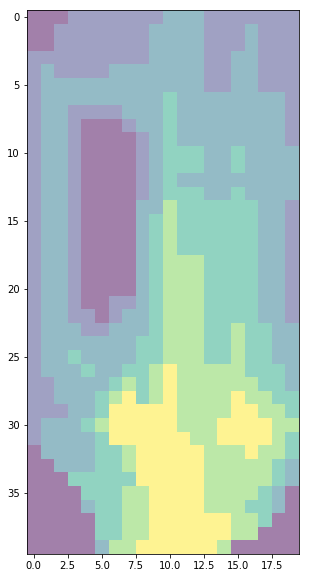

In [35]:
zn_arr = np.loadtxt(os.path.join(working_dir,"hk.zones"))
fig = plt.figure(figsize=(6,10))
ax = plt.subplot(111)
c = ax.imshow(zn_arr,interpolation="nearest",alpha=0.5)
plt.show()

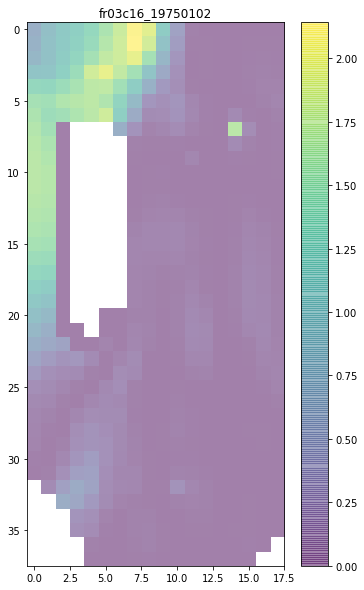

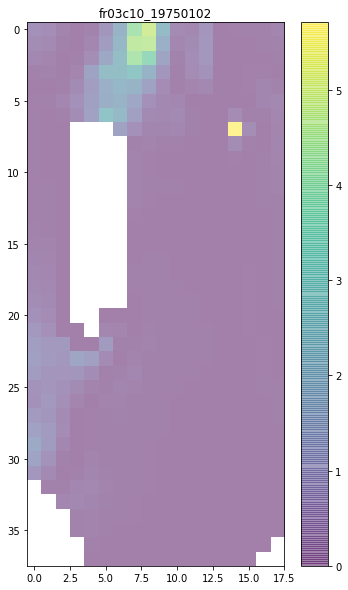

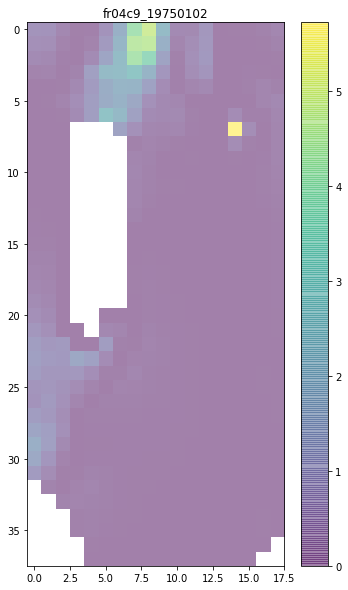

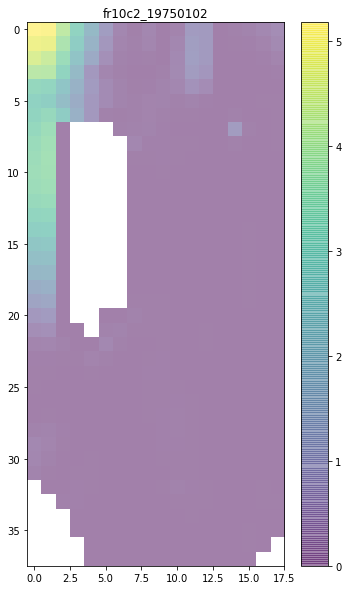

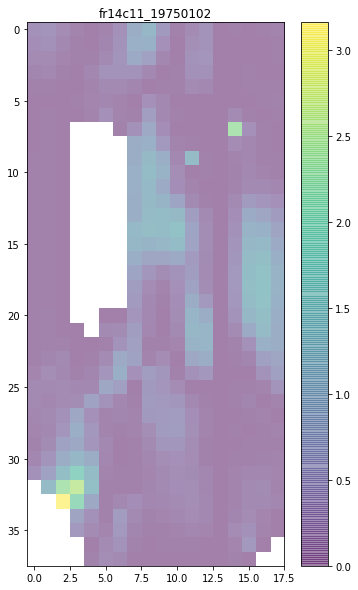

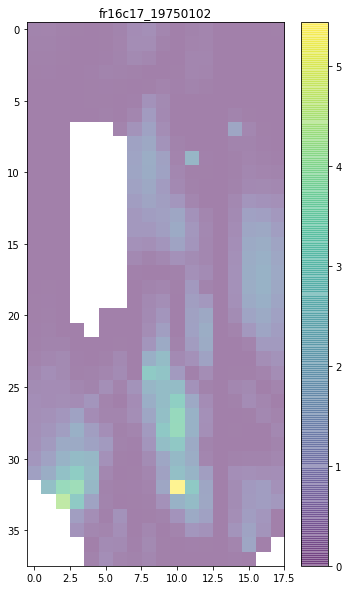

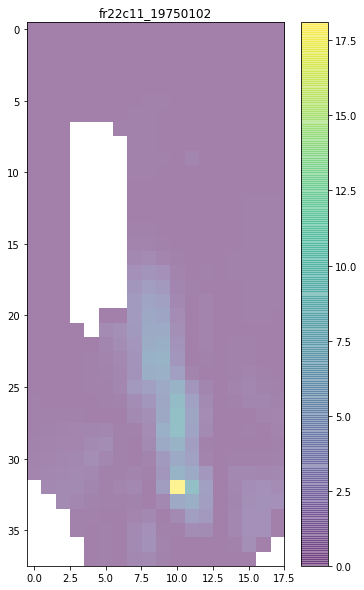

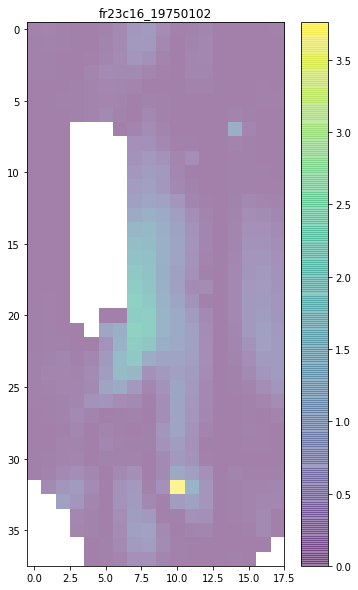

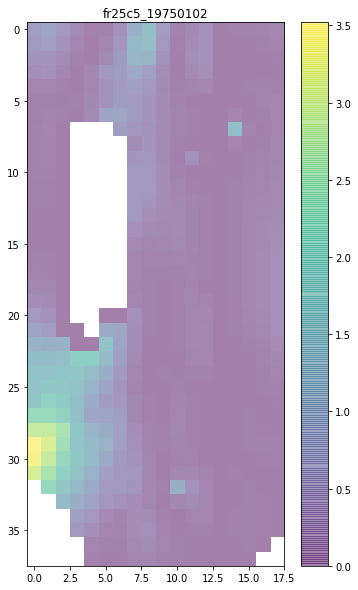

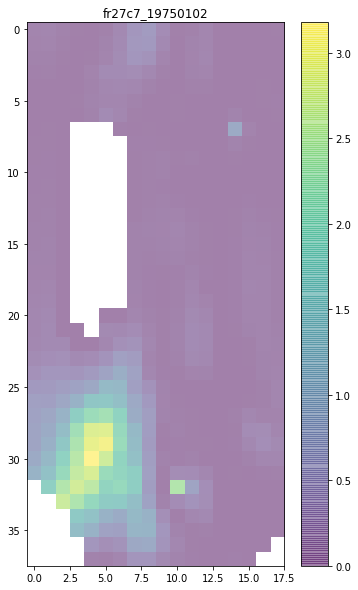

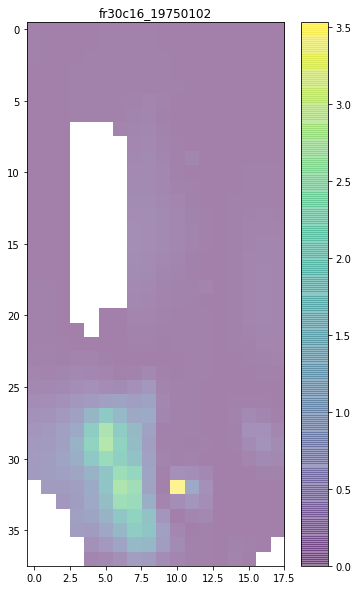

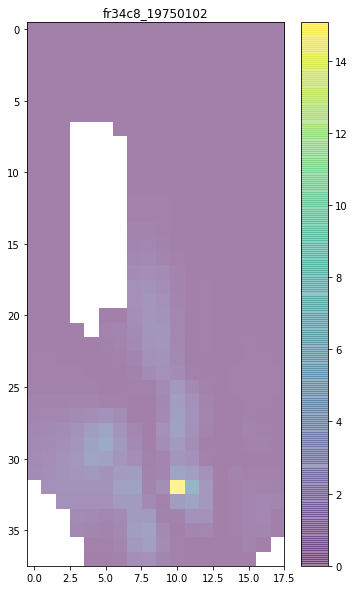

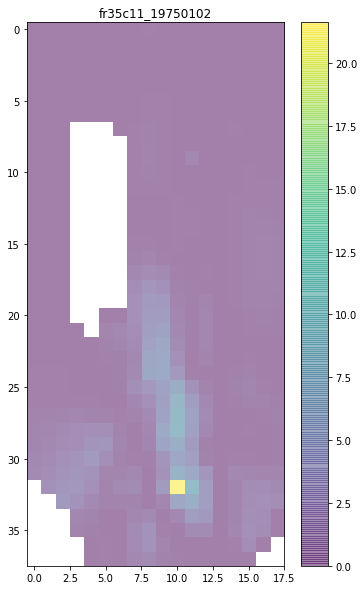

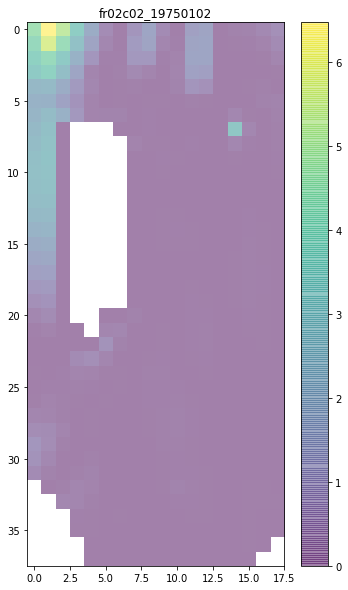

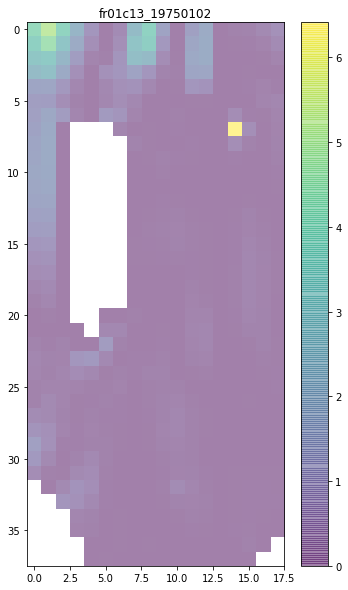

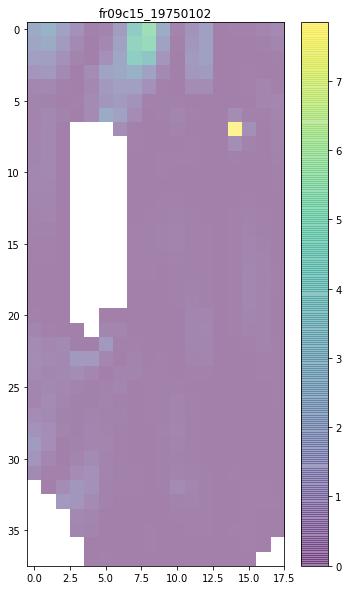

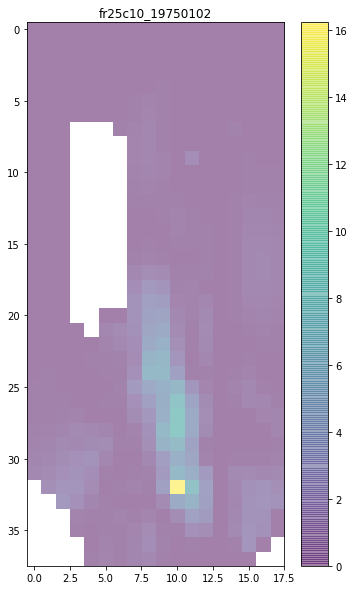

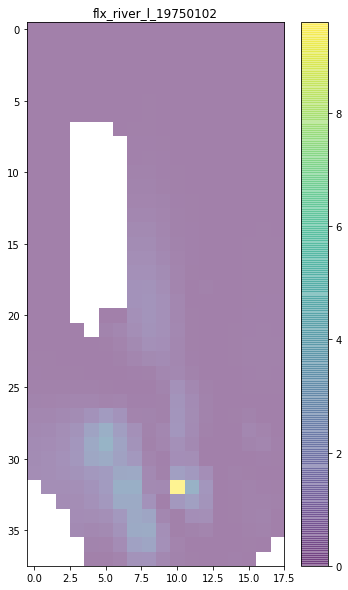

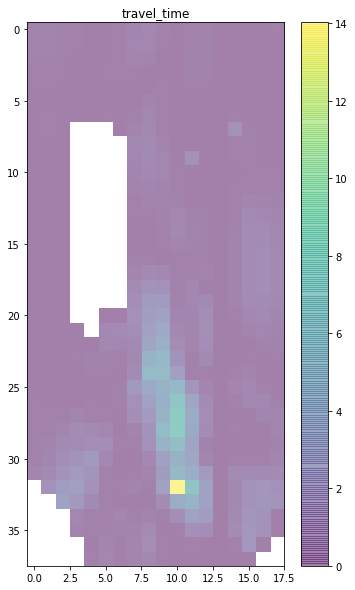

In [36]:
plot_added_worth(df)

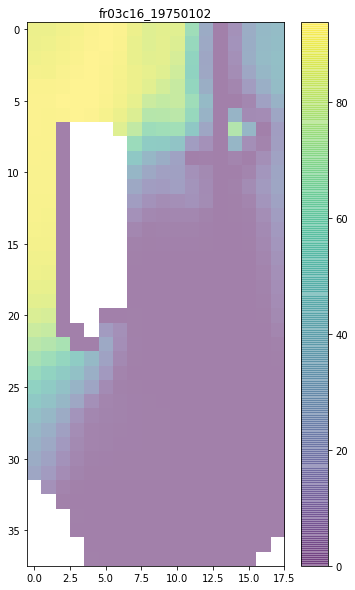

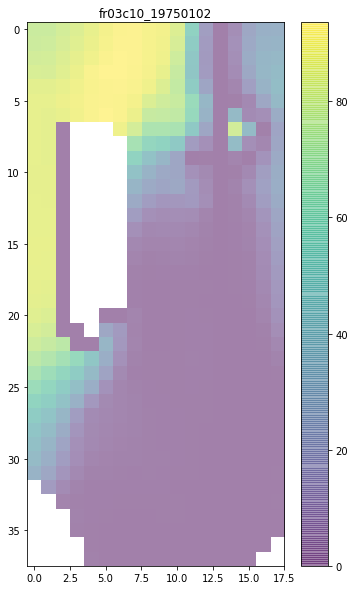

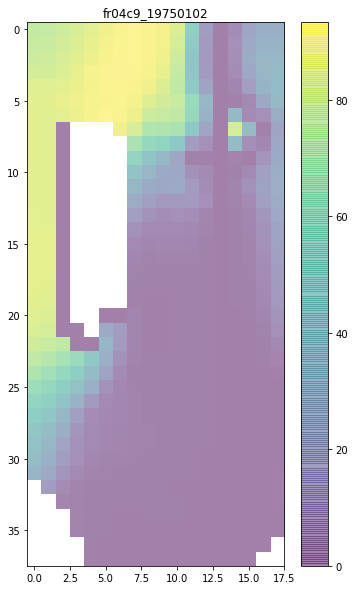

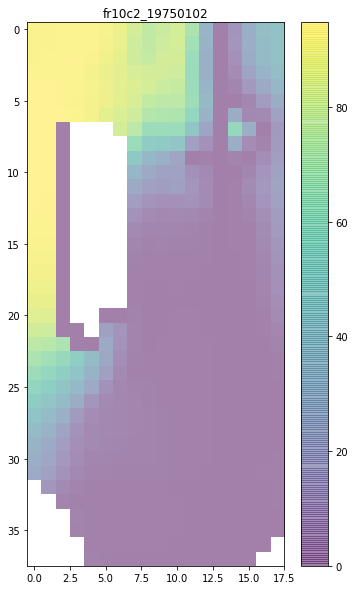

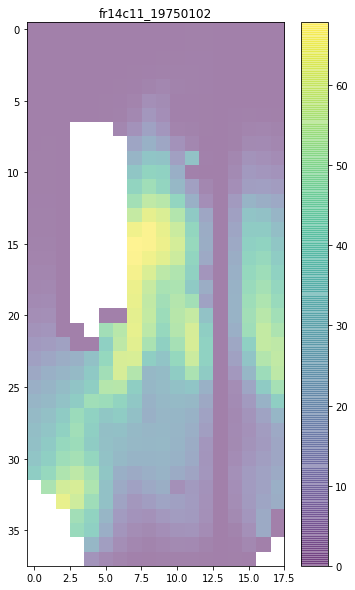

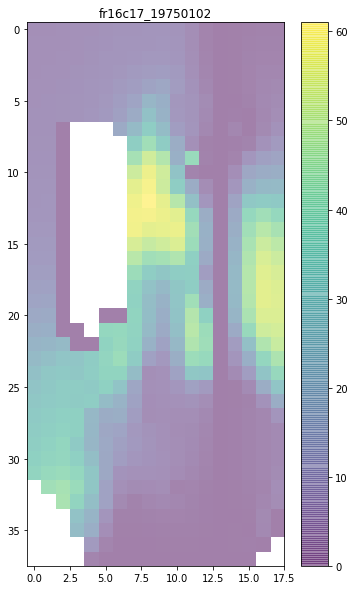

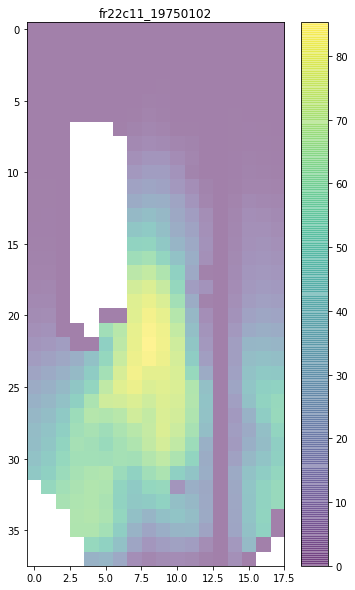

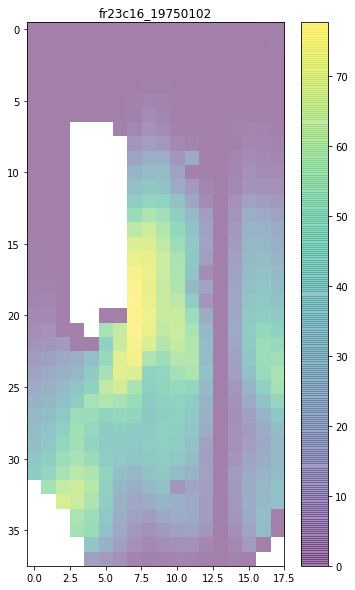

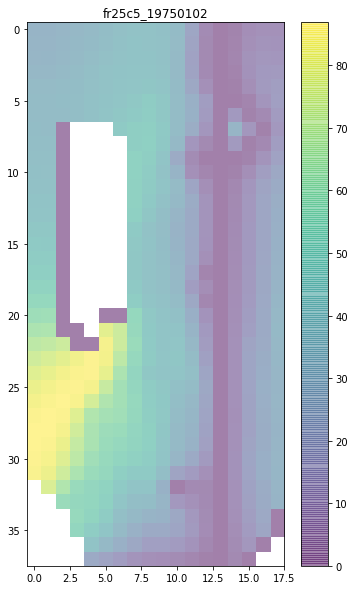

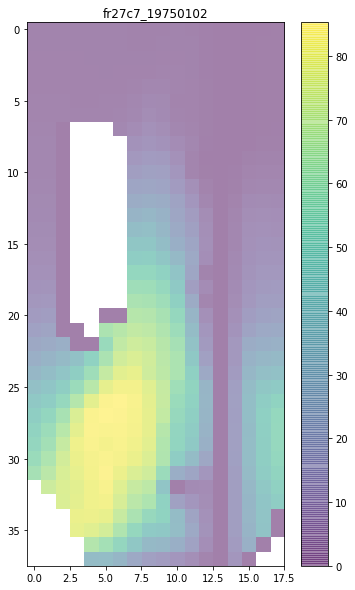

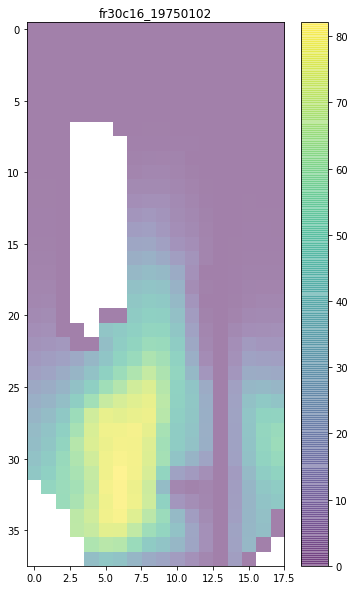

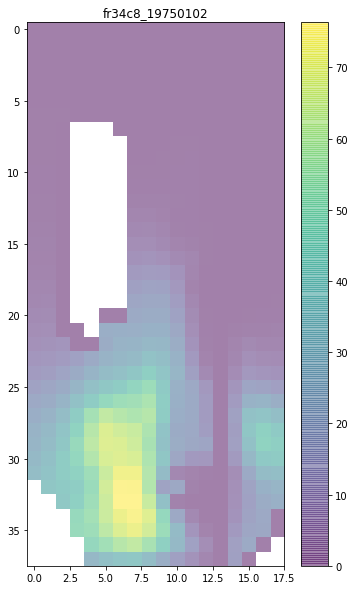

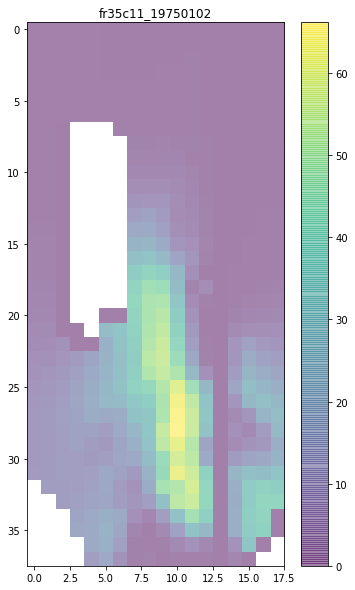

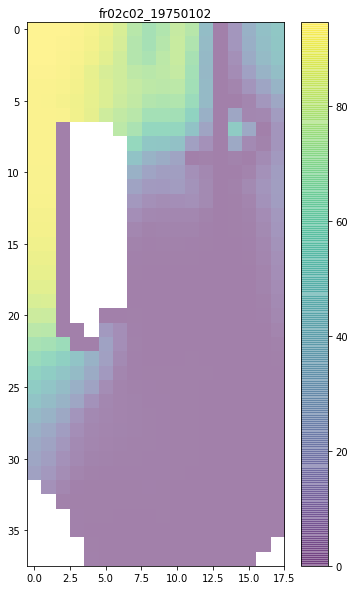

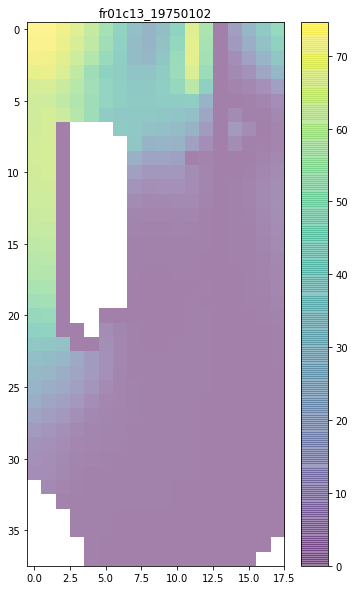

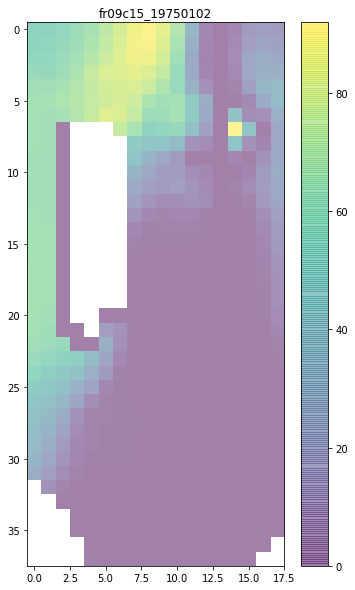

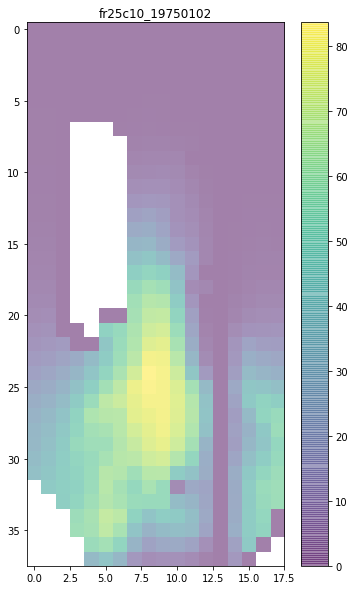

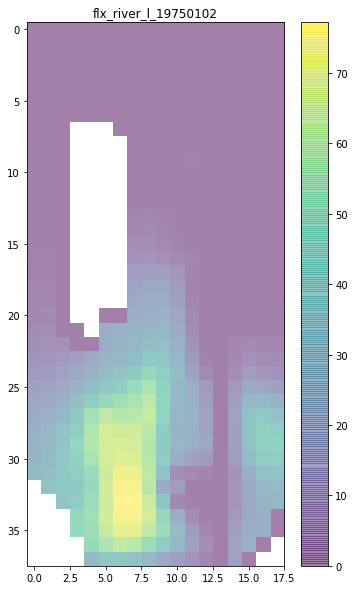

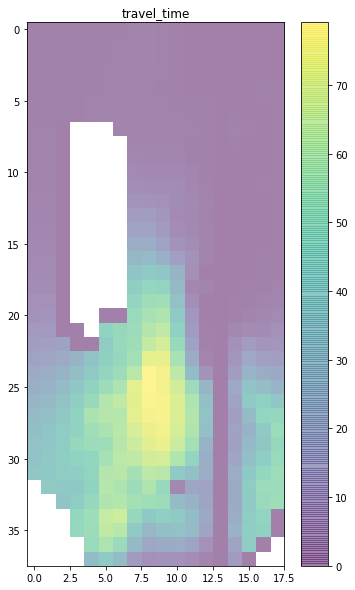

In [37]:
plot_added_worth(df1)